# Protein Secondary Structure Prediction using Hybrid CNN-SVM
### <font color=”blue”> Mount Drive storage </font>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### <font color=”blue”> Install ThunderSVM </font>

In [ ]:
%pip install https://github.com/Xtra-Computing/thundersvm/releases/download/v0.3.4/thundersvm_cuda10.1-0.3.4-cp36-cp36m-linux_x86_64.whl

     |████████████████████████████████| 522kB 1.8MB/s 


### <font color=”blue”>Set Random Seed</font>

In [ ]:
%tensorflow_version 2.x
from numpy.random import seed
seed(1)
#from tensorflow import set_random_seed
#set_random_seed(2)


### <font color=”blue”>Import Libraries</font>

In [ ]:
import numpy as np
from io import StringIO

import tensorflow as tf

from datetime import datetime
import keras

from tensorflow.keras.layers import Input, Dropout, Embedding, Reshape, Dense, Masking, Concatenate
from tensorflow.keras.layers import Convolution1D, MaxPooling1D, ZeroPadding1D
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from keras.models import load_model

from sklearn.externals import joblib

from thundersvm import SVC
from thundersvm import *

import matplotlib.pyplot as plt

np.set_printoptions(threshold=np.inf)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


### <font color=”blue”>Preprocess Data</font>

In [ ]:
preprocess_attribute = {
  "feature" : np.append(np.arange(0,21),np.arange(35,56)),
  "class" : np.arange(22,30),
  "padding" : 21
}

def preprocess_data(data_path, output_path):
    data = np.load(data_path)
    data  = data.reshape(data.shape[0],700,57)
    attribute = np.hstack((
        preprocess_attribute["feature"],
        preprocess_attribute["padding"],
        preprocess_attribute["class"]
    ))

    preprocessed_data = data[:,:,attribute]

    np.save(file = output_path, arr = preprocessed_data)
    print("Data preprocessed! file path: ",output_path)


In [ ]:
cullpdb_data = "/content/drive/My Drive/skripsi/cullpdb+profile_5926_filtered.npy"
prepath = "/content/drive/My Drive/skripsi/preprocessed_filtered.npy"

In [ ]:
preprocess_data(cullpdb_data, prepath)

Data preprocessed! file path:  /content/drive/My Drive/skripsi/preprocessed_filtered.npy


In [ ]:
cb513_prepath = "/content/drive/My Drive/skripsi/cb513+profile_split1.npy"
cb513_outputpath = "/content/drive/My Drive/skripsi/cb513_preprocessed.npy"

In [ ]:
preprocess_data(cb513_prepath, cb513_outputpath)

### <font color=”blue”>Data Object Class</font>

In [ ]:
class Data(object):
  def __init__(self, _prepath):
    self.build(_prepath)

  def read(self, _prepath):
    return np.load(_prepath)

  attribute = {
    "feature" : np.arange(0,42),
    "class" : np.arange(43,51),
    "weight" : np.arange(42,51)
  }

  def build(self, path):
    data = self.read(path)    
    Data.x = data[:,:,Data.attribute["feature"]]
    Data.y = data[:,:,Data.attribute["class"]]
    Data.weight = data[:,:,Data.attribute["weight"]]

In [ ]:
class CBData(object):
  def __init__(self, _prepath):
    self.build(_prepath)

  def read(self, _prepath):
    return np.load(_prepath)

  attribute = {
    "feature" : np.arange(0,42),
    "class" : np.arange(43,51),
    "weight" : np.arange(42,51)
  }

  def build(self, path):
    data = self.read(path)    
    CBData.x = data[:,:,CBData.attribute["feature"]]
    CBData.y = data[:,:,CBData.attribute["class"]]
    CBData.weight = data[:,:,CBData.attribute["weight"]]

### ===================================================================
### CONVOLUTIONAL NEURAL NETWORK
### ===================================================================

### <font color=”blue”>Load CullPDB & CB513 Data</font>

In [ ]:
pdb_data = Data(prepath)

In [ ]:
#The corresponding dataset division for the cullpdb+profile_5926.npy.gz dataset is
index_training = np.arange(0,4292)
index_validation = np.arange(4292, 5365)

In [ ]:
cb513_data = CBData(cb513_outputpath)

### <font color=”blue”>Weighting Function</font> 

In [ ]:
def get_weight(L, B, E, G, I, H, S, T):
  weight_temp = []
  weight_temp = np.argmax(pdb_data.weight, -1)
  print("weight_temp shape: ",weight_temp.shape)

  class_weights = np.zeros(8)
  class_weights[0]= L
  class_weights[1]= B
  class_weights[2]= E
  class_weights[3]= G
  class_weights[4]= I
  class_weights[5]= H
  class_weights[6]= S
  class_weights[7]= T

  sample_weight = np.zeros(3755500)
  sample_weight = sample_weight.reshape(5365, 700)
  print("sample_weight shape: ",sample_weight.shape)
  print(class_weights)
  for i in range(len(sample_weight)):
    for j in range(len(sample_weight[0])):
      if(weight_temp[i][j]==0):
        sample_weight[i][j] = 0
      elif(weight_temp[i][j]==1):
        sample_weight[i][j] = class_weights[0]
      elif(weight_temp[i][j]==2):
        sample_weight[i][j] = class_weights[1]
      elif(weight_temp[i][j]==3):
        sample_weight[i][j] = class_weights[2]
      elif(weight_temp[i][j]==4):
        sample_weight[i][j] = class_weights[3]
      elif(weight_temp[i][j]==5):
        sample_weight[i][j] = class_weights[4]
      elif(weight_temp[i][j]==6):
        sample_weight[i][j] = class_weights[5]
      elif(weight_temp[i][j]==7):
        sample_weight[i][j] = class_weights[6]
      elif(weight_temp[i][j]==8):
        sample_weight[i][j] = class_weights[7]
      
  return sample_weight

### <font color=”blue”>Function for Reporting CNN Test Result</font>

In [ ]:
def test_report_cnn(model_path, input_data, target_data):
    #model = load_model(model_path)
    model = tf.keras.models.load_model(model_path)
    test_result = model.predict(input_data)
    target = target_data
    class_invalid= np.zeros(8)
    
    confussion_matrix = [[0 for column in range(8)] for rows in range(8)]
    
    for sequence_number in range(len(target)):
        for sequence_position in range(len(target[sequence_number])):
            if(not np.array_equal(class_invalid, target[sequence_number][sequence_position])):
                actual_class = np.argmax(target[sequence_number][sequence_position])
                predicted_class = np.argmax(test_result[sequence_number][sequence_position])
                
                confussion_matrix[actual_class][predicted_class] = confussion_matrix[actual_class][predicted_class] + 1
                
    print("\nMODEL_PATH: ",model_path)              
    generate_report_from_matrix(confussion_matrix)

### <font color=”blue”>Function for Showing Confussion Matrices</font>

In [ ]:
def generate_report_from_matrix(matrix):
    class_label = ['L', 'B', 'E', 'G', 'I', 'H', 'S', 'T']
    
    print("\n\033[4m\033[1mCONFUSION MATRIX\033[0m\033[0m")
    print("\n\t\t\t\tPREDICTED\n\n\tL\tB\tE\tG\tI\tH\tS\tT")
    for i in range(len(matrix)):
        numbers = '\t'.join([str(num) for num in matrix[i] ])
        print("\n",class_label[i],"\t", numbers)
        
    print("\n\nAccuracy: ", np.trace(matrix)/np.sum(matrix))
    
    axis_0 = np.sum(matrix, axis=0)
    axis_1 = np.sum(matrix, axis=1)
    axis_0[axis_0 == 0] = 1
    axis_1[axis_1 == 0] = 1
    
    print("\nPrecision L : ", matrix[0][0]/axis_0[0])
    print("Precision B : ", matrix[1][1]/axis_0[1])
    print("Precision E : ", matrix[2][2]/axis_0[2])
    print("Precision G : ", matrix[3][3]/axis_0[3])
    print("Precision I : ", matrix[4][4]/axis_0[4])
    print("Precision H : ", matrix[5][5]/axis_0[5])
    print("Precision S : ", matrix[6][6]/axis_0[6])
    print("Precision T : ", matrix[7][7]/axis_0[7])
        
    print("\nRecall L: ",matrix[0][0]/axis_1[0])
    print("Recall B: ", matrix[1][1]/axis_1[1])
    print("Recall E: ", matrix[2][2]/axis_1[2])
    print("Recall G: ", matrix[3][3]/axis_1[3])
    print("Recall I: ", matrix[4][4]/axis_1[4])
    print("Recall H: ", matrix[5][5]/axis_1[5])
    print("Recall S: ", matrix[6][6]/axis_1[6])
    print("Recall T: ", matrix[7][7]/axis_1[7])


### <font color=”blue”>Train Function</font>

In [ ]:

def train_model(conv_layer_count, conv_size, feature_map):
  #Input Layer
  input_layer = Input(
    shape= (700, 42),
    name='input'
  )

  dropout_layer = Dropout(0.2)(input_layer)

  pool_size = 2
  padding_front = ((conv_size-1)//2)-1
  padding_back = (conv_size-1)-padding_front

  temp_layer = dropout_layer

  for i in range(conv_layer_count):
    #shift_1
    shift_layer_1 = ZeroPadding1D(padding=(padding_front, padding_back))(temp_layer)

    #convolve_1
    convolutional_layer_1 = Convolution1D(
      kernel_size=conv_size, 
      filters=feature_map, 
      padding='valid',
      activation='relu',
      kernel_initializer='glorot_uniform',
      #kernel_regularizer=l2(0.00005), 
      #bias_regularizer=l2(0.005)
    )(shift_layer_1)

    #pool_1
    pooling_1 = MaxPooling1D(pool_size)(convolutional_layer_1)

    #shift_2
    shift_layer_2 = ZeroPadding1D(padding=(padding_back, padding_front))(temp_layer)

    #convolve_2
    convolutional_layer_2 = Convolution1D(
      kernel_size=conv_size, 
      filters=feature_map, 
      padding='valid',
      activation='relu',
      kernel_initializer='glorot_uniform',
      #kernel_regularizer=l2(0.00005), 
      #bias_regularizer=l2(0.005)
    )(shift_layer_2)

    #pool_2
    pooling_2 = MaxPooling1D(pool_size)(convolutional_layer_2)

    #stitch
    merge_layer = Concatenate(axis=2)([pooling_1, pooling_2])
    stitch_layer_shape = (int(merge_layer.get_shape()[1]) * pool_size, feature_map)
    stitch_layer = Reshape(stitch_layer_shape,)(merge_layer)

    dropout_layerc = Dropout(0.5)(stitch_layer)

    temp_layer = dropout_layerc

    
  masking_layer = Masking(mask_value = 0.0,  input_shape=(700, 42))(temp_layer)

  dlayer = TimeDistributed(Dense(
    units=512,
    #kernel_regularizer=l1_l2(l1=0.00001, l2=0.01), bias_regularizer=l1_l2(l1=0.00001, l2=0.01)
    activation='relu',
    #kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)
  ))(masking_layer)

  # Dropout Layer 3
  dropout_layer3 = Dropout(0.5)(dlayer)

  # Output Layer
  output_layer = TimeDistributed(Dense(
    units=8,
    #kernel_regularizer=l1_l2(l1=0.00001, l2=0.01), bias_regularizer=l1_l2(l1=0.00001, l2=0.01)
    activation='softmax',
    name='output',
    #kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)
  ))(dropout_layer3)

  # Compile Model
  model_conv = Model(inputs=input_layer, outputs=output_layer)

  adam = Adam(
    learning_rate=0.0001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07
  )
  
  model_conv.compile(
    optimizer=adam,
    loss=['categorical_crossentropy'],
    sample_weight_mode='temporal',
    metrics=['accuracy']
  )

  #checkpoint_path = "/content/drive/My Drive/skripsi/run2/model_deep_"+str(conv_layer_count)+"_conv_"+str(conv_size)+"_featuremap_"+str(feature_map)+"-{epoch:04d}.ckpt"
  #from keras.callbacks import ModelCheckpoint
  #cp_callback = ModelCheckpoint(
  #  filepath=checkpoint_path, 
  #  verbose=1, 
  #  save_weights_only=False,
  #  period=10)
  
  #csv_path = "/content/drive/My Drive/skripsi/run2/model_deep_"+str(conv_layer_count)+"_conv_"+str(conv_size)+"_featuremap_"+str(feature_map)+".csv"
  #from keras.callbacks import CSVLogger
  #csv_logger = CSVLogger(csv_path, append=True)

  from tensorflow.keras.callbacks import EarlyStopping	
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30, restore_best_weights=True)

  start=datetime.now()
  history_conv = model_conv.fit(
    x = pdb_data.x[index_training], 
    y = pdb_data.y[index_training], 
    validation_data = (pdb_data.x[index_validation],pdb_data.y[index_validation], weight[index_validation]),
    epochs = 200,
    verbose=0,
    initial_epoch = 0,
    sample_weight = weight[index_training],
    shuffle=True,
    callbacks=[es]#cp_callback, csv_logger,]
  )
  print("\n",conv_layer_count," ",conv_size," ",feature_map,"\nTraining time: ", datetime.now()-start)

  file_path = "/content/drive/My Drive/skripsi/run2/dif2model_deep_"+str(conv_layer_count)+"_conv_"+str(conv_size)+"_featuremap_"+str(feature_map)+".h5"
   
  model_conv.save(
    filepath=file_path
  )
    
  print("\n\033[4m\033[1mmodel_deep_"+str(conv_layer_count)+"_ conv_"+str(conv_size)+"_featuremap_"+str(feature_map)+"\033[0m\033[0m")
  plt.plot(history_conv.history['accuracy'])
  plt.plot(history_conv.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Validation'], loc='lower left')
  plt.ylim(ymin=0.7)
  plt.ylim(ymax=1)
  plt.show()

  plt.plot(history_conv.history['loss'])
  plt.plot(history_conv.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Validation'], loc='upper left')
  plt.ylim(ymax=1)
  plt.show()
    
  start=datetime.now()
  test_report_cnn(file_path, cb513_data.x, cb513_data.y)
  print("Testing time: ",datetime.now()-start)

### <font color=”blue”>Train & Test CNN Model</font>

weight_temp shape:  (5365, 700)
sample_weight shape:  (5365, 700)
[1.  1.  1.  1.  0.1 1.  1.2 1.1]

 2   8   512 
Training time:  0:38:05.835495

model_deep_2_ conv_8_featuremap_512


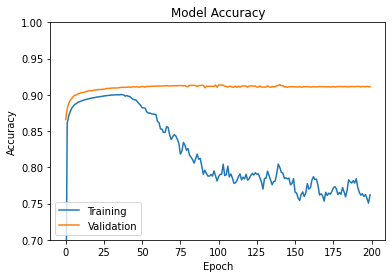

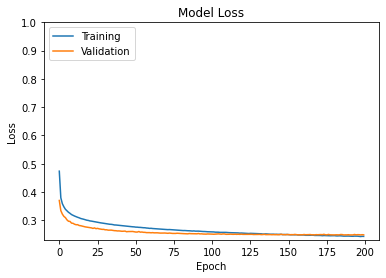


MODEL_PATH:  /content/drive/My Drive/skripsi/run2/dif2model_deep_2_conv_8_featuremap_512.h5

CONFUSION MATRIX

				PREDICTED

	L	B	E	G	I	H	S	T

 L 	 11110	12	2818	162	0	1056	1329	1433

 B 	 575	25	309	8	0	93	73	98

 E 	 2320	14	14371	46	0	573	297	395

 G 	 594	0	183	733	0	881	124	617

 I 	 5	0	0	0	0	20	2	3

 H 	 761	0	360	236	0	23902	132	766

 S 	 2958	2	796	110	0	689	2174	1587

 T 	 1583	0	426	335	0	1716	636	5317


Accuracy:  0.6799032619595352

Precision L :  0.5581231789410228
Precision B :  0.4716981132075472
Precision E :  0.7460416342210455
Precision G :  0.44969325153374234
Precision I :  0.0
Precision H :  0.8262011752506049
Precision S :  0.45605202433396264
Precision T :  0.5204581049334377

Recall L:  0.6199776785714286
Recall B:  0.021168501270110076
Recall E:  0.7976798401420959
Recall G:  0.23403575989782888
Recall I:  0.0
Recall H:  0.9137898076996598
Recall S:  0.26142376142376145
Recall T:  0.5310096874063717
Testing time:  0:00:02.839904
Restoring model weights from 

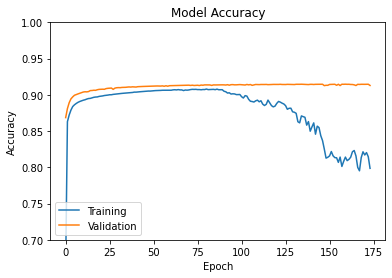

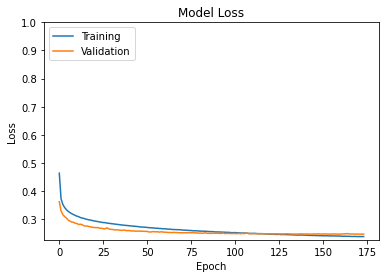


MODEL_PATH:  /content/drive/My Drive/skripsi/run2/dif2model_deep_2_conv_9_featuremap_512.h5

CONFUSION MATRIX

				PREDICTED

	L	B	E	G	I	H	S	T

 L 	 11077	12	2969	135	0	1014	1307	1406

 B 	 589	21	304	8	0	91	75	93

 E 	 2239	15	14512	43	0	492	320	395

 G 	 604	0	211	736	0	888	110	583

 I 	 4	0	2	0	0	20	0	4

 H 	 759	0	381	214	0	23984	129	690

 S 	 3024	0	853	100	0	667	2118	1554

 T 	 1633	3	480	327	0	1740	628	5202


Accuracy:  0.6801156137556774

Precision L :  0.5558231722615284
Precision B :  0.4117647058823529
Precision E :  0.7362012987012987
Precision G :  0.4708893154190659
Precision I :  0.0
Precision H :  0.8300110741971207
Precision S :  0.4518882014081502
Precision T :  0.5240253853127833

Recall L:  0.6181361607142857
Recall B:  0.017781541066892465
Recall E:  0.80550621669627
Recall G:  0.23499361430395913
Recall I:  0.0
Recall H:  0.9169247237833085
Recall S:  0.2546897546897547
Recall T:  0.5195246179966044
Testing time:  0:00:02.842882

 2   10   512 
Training time:  0:

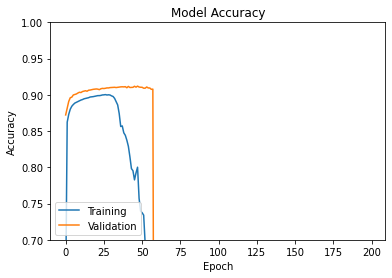

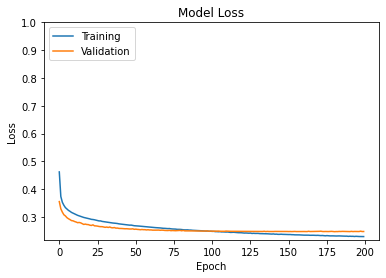


MODEL_PATH:  /content/drive/My Drive/skripsi/run2/dif2model_deep_2_conv_10_featuremap_512.h5

CONFUSION MATRIX

				PREDICTED

	L	B	E	G	I	H	S	T

 L 	 11172	9	2787	178	0	978	1371	1425

 B 	 568	30	291	11	0	86	86	109

 E 	 2304	16	14391	49	0	490	352	414

 G 	 615	0	199	739	0	851	139	589

 I 	 5	0	0	0	0	20	2	3

 H 	 750	1	350	252	0	23895	125	784

 S 	 2889	3	789	109	0	652	2276	1598

 T 	 1593	3	474	325	0	1709	690	5219


Accuracy:  0.6809650209402466

Precision L :  0.5615199034981906
Precision B :  0.4838709677419355
Precision E :  0.7463824490430995
Precision G :  0.444377630787733
Precision I :  0.0
Precision H :  0.8331299466545797
Precision S :  0.4514977187066058
Precision T :  0.5146435262794596

Recall L:  0.6234375
Recall B:  0.02540220152413209
Recall E:  0.7987899644760214
Recall G:  0.2359514687100894
Recall I:  0.0
Recall H:  0.9135221929120312
Recall S:  0.2736892736892737
Recall T:  0.5212224108658744
Testing time:  0:00:02.870817


In [ ]:
#checktrain
weight = get_weight(
  1, #L
  1, #B
  1, #E 
  1, #G
  0.1, #I
  1, #H
  1.2, #S
  1.1   #T
)
convolution_layer = [2]
convolution_size = [8,9,10]
featuremap = [512]

for k in range(len(featuremap)):
  for i in range(len(convolution_layer)):
    for j in range(len(convolution_size)):
      train_model(convolution_layer[i], convolution_size[j], featuremap[k])
            

weight_temp shape:  (5365, 700)
sample_weight shape:  (5365, 700)
[1.  1.  1.  1.  0.1 1.  1.2 1.1]

 1   6   1024 
Training time:  0:16:33.141206

model_deep_1_ conv_6_featuremap_1024


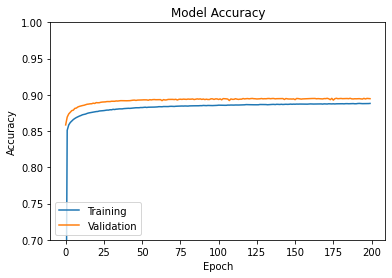

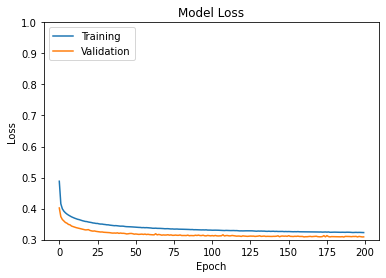


MODEL_PATH:  /content/drive/My Drive/skripsi/run2/dif2model_deep_1_conv_6_featuremap_1024.h5

CONFUSION MATRIX

				PREDICTED

	L	B	E	G	I	H	S	T

 L 	 10547	0	2700	22	0	2227	806	1618

 B 	 514	0	318	1	0	199	52	97

 E 	 2580	0	12262	6	0	2413	211	544

 G 	 636	0	196	198	0	1372	102	628

 I 	 4	0	2	1	0	16	0	7

 H 	 1197	0	891	62	0	23031	134	842

 S 	 3212	0	796	20	0	1256	1325	1707

 T 	 1756	0	523	58	0	2378	423	4875


Accuracy:  0.6162685070488999

Precision L :  0.5158466203658417
Precision B :  0.0
Precision E :  0.6932383536861149
Precision G :  0.5380434782608695
Precision I :  0.0
Precision H :  0.700200656694637
Precision S :  0.4339993449066492
Precision T :  0.4724752859081217

Recall L:  0.5885602678571429
Recall B:  0.0
Recall E:  0.6806172291296625
Recall G:  0.06321839080459771
Recall I:  0.0
Recall H:  0.8804908819818786
Recall S:  0.15933140933140932
Recall T:  0.486867072805353
Testing time:  0:00:02.520420

 1   7   1024 
Training time:  0:17:06.043764

model_deep_1_ conv_7

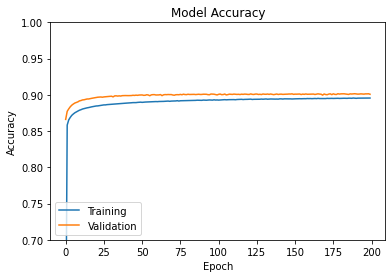

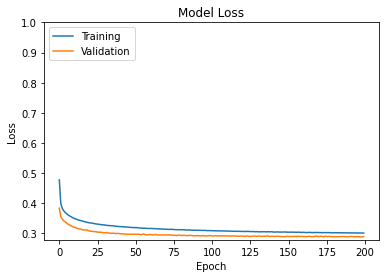


MODEL_PATH:  /content/drive/My Drive/skripsi/run2/dif2model_deep_1_conv_7_featuremap_1024.h5

CONFUSION MATRIX

				PREDICTED

	L	B	E	G	I	H	S	T

 L 	 11071	1	2488	40	0	1852	982	1486

 B 	 593	1	261	2	0	175	60	89

 E 	 2640	2	12665	7	0	1979	244	479

 G 	 607	0	160	334	0	1338	102	591

 I 	 2	0	3	0	0	20	0	5

 H 	 1016	1	716	83	0	23491	136	714

 S 	 3189	0	706	45	0	1136	1625	1615

 T 	 1650	0	440	111	0	2340	521	4951


Accuracy:  0.6386834188639179

Precision L :  0.5330797380585516
Precision B :  0.2
Precision E :  0.7262457709731063
Precision G :  0.5369774919614148
Precision I :  0.0
Precision H :  0.7265782066747085
Precision S :  0.4427792915531335
Precision T :  0.4985901309164149

Recall L:  0.6178013392857142
Recall B:  0.000846740050804403
Recall E:  0.7029862344582594
Recall G:  0.10664112388250319
Recall I:  0.0
Recall H:  0.8980769965974691
Recall S:  0.19540644540644542
Recall T:  0.49445720563267753
Testing time:  0:00:02.665877

 1   8   1024 
Training time:  0:17:30.415323


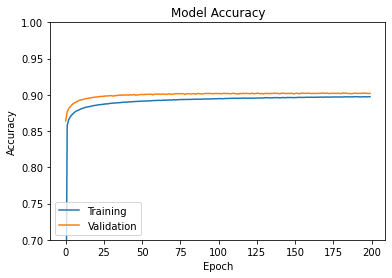

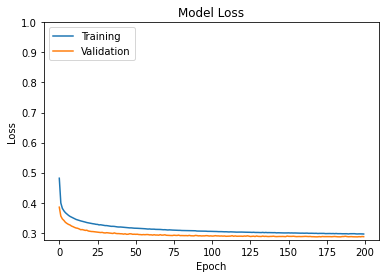


MODEL_PATH:  /content/drive/My Drive/skripsi/run2/dif2model_deep_1_conv_8_featuremap_1024.h5

CONFUSION MATRIX

				PREDICTED

	L	B	E	G	I	H	S	T

 L 	 10993	0	2709	51	0	1764	898	1505

 B 	 568	0	289	3	0	149	60	112

 E 	 2491	2	12985	15	0	1805	243	475

 G 	 596	0	173	359	0	1268	105	631

 I 	 3	0	3	0	0	19	0	5

 H 	 1024	0	721	88	0	23407	150	767

 S 	 3272	0	794	52	0	1043	1507	1648

 T 	 1696	0	497	127	0	2249	457	4987


Accuracy:  0.6398631510647083

Precision L :  0.5325291866492273
Precision B :  0.0
Precision E :  0.7146001871113312
Precision G :  0.516546762589928
Precision I :  0.0
Precision H :  0.7382980065606863
Precision S :  0.44064327485380117
Precision T :  0.4923000987166831

Recall L:  0.6134486607142857
Recall B:  0.0
Recall E:  0.7207482238010657
Recall G:  0.11462324393358876
Recall I:  0.0
Recall H:  0.8948656191459265
Recall S:  0.18121693121693122
Recall T:  0.4980525317087786
Testing time:  0:00:02.532322

 1   9   1024 
Training time:  0:17:19.959120

model_deep_1_ c

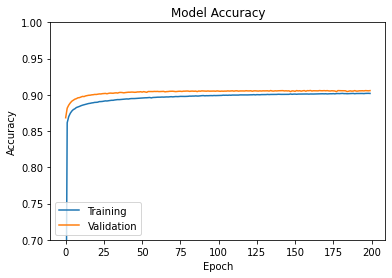

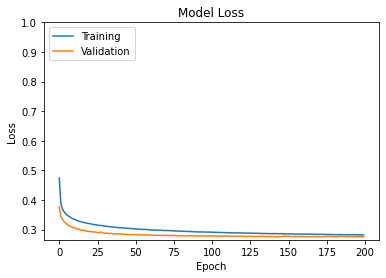


MODEL_PATH:  /content/drive/My Drive/skripsi/run2/dif2model_deep_1_conv_9_featuremap_1024.h5

CONFUSION MATRIX

				PREDICTED

	L	B	E	G	I	H	S	T

 L 	 10930	1	2923	72	0	1500	1108	1386

 B 	 569	1	302	7	0	127	80	95

 E 	 2336	1	13558	25	0	1386	257	453

 G 	 570	0	205	411	0	1246	109	591

 I 	 3	0	2	0	0	20	0	5

 H 	 893	1	658	95	0	23723	139	648

 S 	 3147	0	883	63	0	948	1734	1541

 T 	 1693	0	526	170	0	2152	561	4911


Accuracy:  0.6520143927328497

Precision L :  0.5426741472618043
Precision B :  0.25
Precision E :  0.7114446135278375
Precision G :  0.4875444839857651
Precision I :  0.0
Precision H :  0.7627483763102051
Precision S :  0.43480441323971913
Precision T :  0.509968847352025

Recall L:  0.6099330357142857
Recall B:  0.000846740050804403
Recall E:  0.7525532859680284
Recall G:  0.13122605363984674
Recall I:  0.0
Recall H:  0.9069465152731583
Recall S:  0.2085137085137085
Recall T:  0.4904623988814541
Testing time:  0:00:02.453689
Restoring model weights from the end of the best

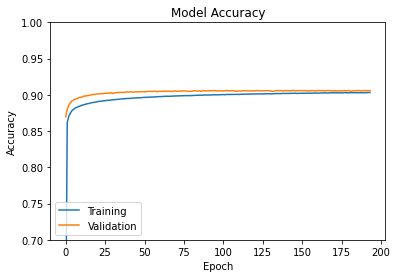

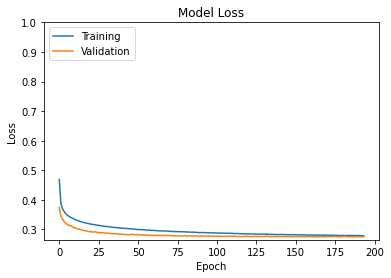


MODEL_PATH:  /content/drive/My Drive/skripsi/run2/dif2model_deep_1_conv_10_featuremap_1024.h5

CONFUSION MATRIX

				PREDICTED

	L	B	E	G	I	H	S	T

 L 	 10507	0	3117	92	0	1457	1096	1651

 B 	 562	1	303	5	0	127	77	106

 E 	 2106	1	13892	19	0	1263	256	479

 G 	 530	0	208	465	0	1183	97	649

 I 	 2	0	3	0	0	20	1	4

 H 	 833	0	723	123	0	23625	137	716

 S 	 3005	0	945	64	0	941	1678	1683

 T 	 1525	0	565	183	0	2059	530	5151


Accuracy:  0.6526160561552528

Precision L :  0.5509701101206083
Precision B :  0.5
Precision E :  0.7031787811297834
Precision G :  0.4889589905362776
Precision I :  0.0
Precision H :  0.7701711491442543
Precision S :  0.43336776859504134
Precision T :  0.49343806878053453

Recall L:  0.586328125
Recall B:  0.000846740050804403
Recall E:  0.7710923623445826
Recall G:  0.14846743295019157
Recall I:  0.0
Recall H:  0.9031999082463585
Recall S:  0.20177970177970178
Recall T:  0.5144312393887945
Testing time:  0:00:02.483083


weight_temp shape:  (5365, 700)
sample_weight shape:  (5365, 700)
[1.  1.  1.  1.  0.1 1.  1.2 1.1]
Restoring model weights from the end of the best epoch.
Epoch 00172: early stopping

 2   6   1024 
Training time:  1:24:33.559112

model_deep_2_ conv_6_featuremap_1024


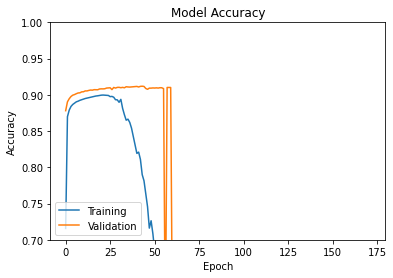

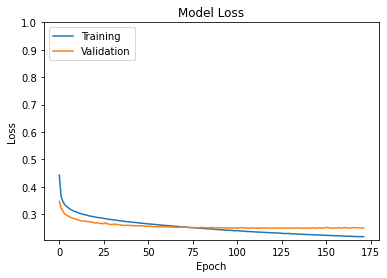


MODEL_PATH:  /content/drive/My Drive/skripsi/run2/dif2model_deep_2_conv_6_featuremap_1024.h5

CONFUSION MATRIX

				PREDICTED

	L	B	E	G	I	H	S	T

 L 	 10649	18	3164	159	0	1183	1460	1287

 B 	 509	41	325	5	0	109	105	87

 E 	 1902	17	14604	45	0	706	374	368

 G 	 524	0	232	705	0	974	169	528

 I 	 4	0	2	0	0	20	0	4

 H 	 663	1	416	226	0	24049	143	659

 S 	 2682	7	929	132	0	777	2418	1371

 T 	 1451	4	538	324	0	1844	747	5105


Accuracy:  0.679183625317053

Precision L :  0.5792536988685814
Precision B :  0.4659090909090909
Precision E :  0.7226125680356259
Precision G :  0.4417293233082707
Precision I :  0.0
Precision H :  0.810767985975322
Precision S :  0.44645494830132937
Precision T :  0.542565628653417

Recall L:  0.5942522321428572
Recall B:  0.03471634208298052
Recall E:  0.8106127886323268
Recall G:  0.22509578544061304
Recall I:  0.0
Recall H:  0.9194097182398593
Recall S:  0.2907647907647908
Recall T:  0.5098372116248876
Testing time:  0:00:03.375994
Restoring model weights from the

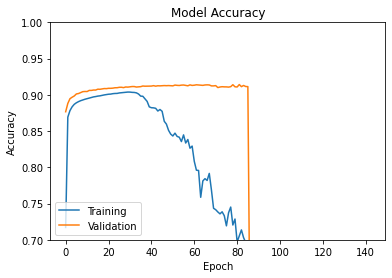

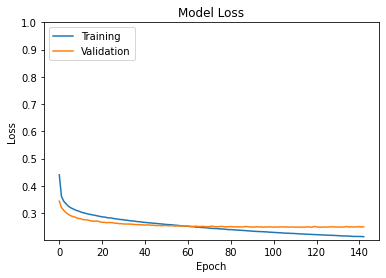


MODEL_PATH:  /content/drive/My Drive/skripsi/run2/dif2model_deep_2_conv_7_featuremap_1024.h5

CONFUSION MATRIX

				PREDICTED

	L	B	E	G	I	H	S	T

 L 	 10946	14	3036	178	0	1105	1282	1359

 B 	 541	32	324	9	0	88	97	90

 E 	 2063	15	14463	67	0	672	331	405

 G 	 554	1	208	800	0	886	150	533

 I 	 3	0	2	0	0	20	2	3

 H 	 720	3	452	246	0	23893	140	703

 S 	 2845	8	889	138	0	691	2205	1540

 T 	 1581	4	500	359	0	1808	630	5131


Accuracy:  0.6779920957942547

Precision L :  0.5685347738014855
Precision B :  0.4155844155844156
Precision E :  0.7277347287913857
Precision G :  0.44518642181413465
Precision I :  0.0
Precision H :  0.8192915680828446
Precision S :  0.4558610709117221
Precision T :  0.5255018435067595

Recall L:  0.6108258928571428
Recall B:  0.027095681625740897
Recall E:  0.8027864120781527
Recall G:  0.2554278416347382
Recall I:  0.0
Recall H:  0.9134457315441373
Recall S:  0.26515151515151514
Recall T:  0.5124338360131828
Testing time:  0:00:03.592405
Restoring model weights from t

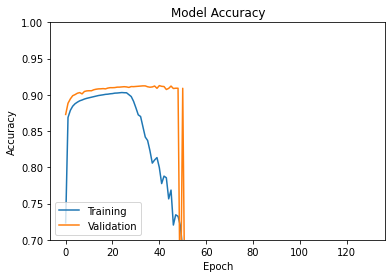

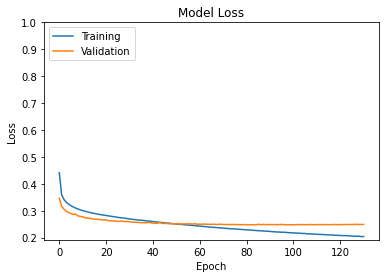


MODEL_PATH:  /content/drive/My Drive/skripsi/run2/dif2model_deep_2_conv_8_featuremap_1024.h5

CONFUSION MATRIX

				PREDICTED

	L	B	E	G	I	H	S	T

 L 	 10715	17	2923	191	0	1125	1566	1383

 B 	 520	35	324	19	0	102	89	92

 E 	 2131	19	14340	82	0	660	374	410

 G 	 522	0	189	764	0	923	173	561

 I 	 3	0	1	0	0	21	0	5

 H 	 657	1	377	231	0	24039	170	682

 S 	 2632	6	823	149	0	752	2418	1536

 T 	 1463	6	472	385	0	1873	713	5101


Accuracy:  0.6773078511177962

Precision L :  0.5747465536662554
Precision B :  0.4166666666666667
Precision E :  0.7373129723893259
Precision G :  0.4195496979681494
Precision I :  0.0
Precision H :  0.8150194948296321
Precision S :  0.4393966927130656
Precision T :  0.5221084953940635

Recall L:  0.5979352678571429
Recall B:  0.029635901778154106
Recall E:  0.7959591474245116
Recall G:  0.24393358876117496
Recall I:  0.0
Recall H:  0.9190274114003899
Recall S:  0.2907647907647908
Recall T:  0.5094377309497653
Testing time:  0:00:03.576509
Restoring model weights from 

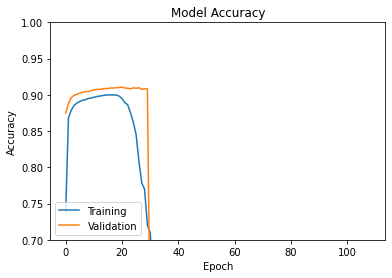

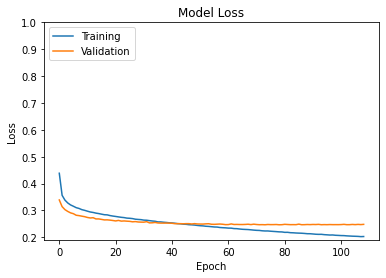


MODEL_PATH:  /content/drive/My Drive/skripsi/run2/dif2model_deep_2_conv_9_featuremap_1024.h5

CONFUSION MATRIX

				PREDICTED

	L	B	E	G	I	H	S	T

 L 	 10592	14	3093	142	0	1166	1372	1541

 B 	 532	32	323	6	0	99	83	106

 E 	 2029	17	14585	34	0	582	343	426

 G 	 493	0	216	709	0	981	133	600

 I 	 3	0	2	0	0	20	1	4

 H 	 623	1	359	209	0	24044	153	768

 S 	 2699	4	884	106	0	761	2213	1649

 T 	 1351	0	499	308	0	1812	671	5372


Accuracy:  0.6789004895888633

Precision L :  0.5781028272022705
Precision B :  0.47058823529411764
Precision E :  0.7306748158909874
Precision G :  0.46829590488771466
Precision I :  0.0
Precision H :  0.8160190055998643
Precision S :  0.4453612396860535
Precision T :  0.5132811007070514

Recall L:  0.5910714285714286
Recall B:  0.027095681625740897
Recall E:  0.8095581705150977
Recall G:  0.22637292464878672
Recall I:  0.0
Recall H:  0.9192185648201247
Recall S:  0.26611351611351614
Recall T:  0.5365025466893039
Testing time:  0:00:03.640890
Restoring model weights fro

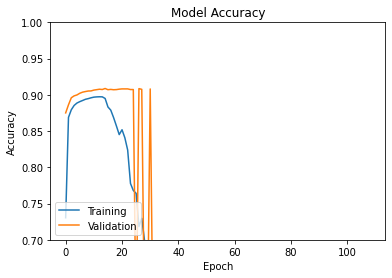

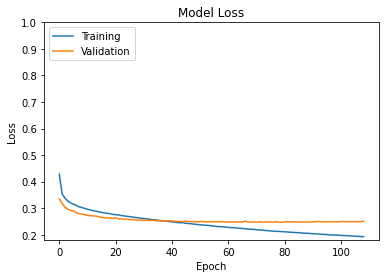


MODEL_PATH:  /content/drive/My Drive/skripsi/run2/dif2model_deep_2_conv_10_featuremap_1024.h5

CONFUSION MATRIX

				PREDICTED

	L	B	E	G	I	H	S	T

 L 	 10805	24	2954	198	0	1092	1447	1400

 B 	 527	44	297	11	0	97	102	103

 E 	 2158	25	14472	60	0	539	387	375

 G 	 579	0	191	793	0	856	134	579

 I 	 6	0	0	1	0	18	0	5

 H 	 687	1	378	275	0	23928	153	735

 S 	 2826	8	904	121	0	668	2242	1547

 T 	 1541	4	491	339	0	1800	694	5144


Accuracy:  0.6774966082699228

Precision L :  0.5648491818704585
Precision B :  0.41509433962264153
Precision E :  0.7351043836033931
Precision G :  0.4410456062291435
Precision I :  0.0
Precision H :  0.8251603558866129
Precision S :  0.4345803450281062
Precision T :  0.5202265372168284

Recall L:  0.6029575892857143
Recall B:  0.03725656223539373
Recall E:  0.8032859680284192
Recall G:  0.25319284802043424
Recall I:  0.0
Recall H:  0.9147838054822801
Recall S:  0.2696007696007696
Recall T:  0.5137321482073305
Testing time:  0:00:03.710025


weight_temp shape:  (5365, 700)
sample_weight shape:  (5365, 700)
[1.  1.  1.  1.  0.1 1.  1.2 1.1]
Restoring model weights from the end of the best epoch.
Epoch 00106: early stopping

 3   6   1024 
Training time:  1:35:28.949344

model_deep_3_ conv_6_featuremap_1024


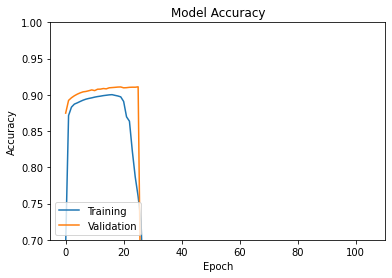

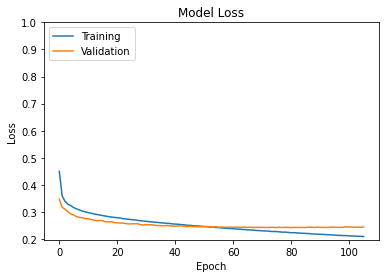


MODEL_PATH:  /content/drive/My Drive/skripsi/run2/dif2model_deep_3_conv_6_featuremap_1024.h5

CONFUSION MATRIX

				PREDICTED

	L	B	E	G	I	H	S	T

 L 	 10892	14	3178	239	0	953	1267	1377

 B 	 556	34	309	14	0	89	85	94

 E 	 1938	21	14866	63	0	430	322	376

 G 	 570	0	221	879	0	818	113	531

 I 	 4	0	1	1	0	18	1	5

 H 	 652	3	365	285	0	24019	119	714

 S 	 2804	5	988	163	0	620	2113	1623

 T 	 1488	2	542	456	0	1724	587	5214


Accuracy:  0.6844452309325783

Precision L :  0.57617435463394
Precision B :  0.43037974683544306
Precision E :  0.7262335124572545
Precision G :  0.4185714285714286
Precision I :  0.0
Precision H :  0.837745457082069
Precision S :  0.45864988061645323
Precision T :  0.5248641030803302

Recall L:  0.6078125
Recall B:  0.028789161727349702
Recall E:  0.8251554174067496
Recall G:  0.28065134099616856
Recall I:  0.0
Recall H:  0.9182627977214513
Recall S:  0.2540885040885041
Recall T:  0.5207230600219714
Testing time:  0:00:04.284755


weight_temp shape:  (5365, 700)
sample_weight shape:  (5365, 700)
[1.  1.  1.  1.  0.1 1.  1.2 1.1]
Restoring model weights from the end of the best epoch.
Epoch 00092: early stopping

 4   8   1024 
Training time:  2:25:13.280627

model_deep_4_ conv_8_featuremap_1024


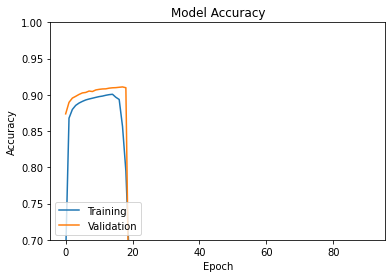

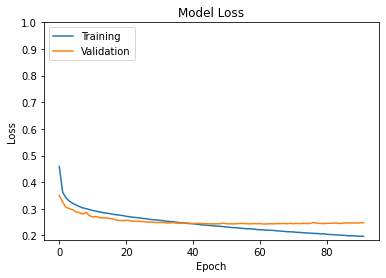


MODEL_PATH:  /content/drive/My Drive/skripsi/run2/dif2model_deep_4_conv_8_featuremap_1024.h5

CONFUSION MATRIX

				PREDICTED

	L	B	E	G	I	H	S	T

 L 	 11221	18	2842	286	0	939	1328	1286

 B 	 573	29	281	23	0	102	80	93

 E 	 2245	21	14586	105	0	391	312	356

 G 	 569	0	185	916	0	838	104	520

 I 	 7	0	0	0	0	18	0	5

 H 	 720	4	322	382	0	23944	132	653

 S 	 2982	3	801	198	0	633	2166	1533

 T 	 1589	2	450	479	0	1773	574	5146


Accuracy:  0.6843390550345072

Precision L :  0.5636993871194614
Precision B :  0.37662337662337664
Precision E :  0.7492679919864386
Precision G :  0.38342402678945164
Precision I :  0.0
Precision H :  0.8360919058593477
Precision S :  0.4612436115843271
Precision T :  0.536488740617181

Recall L:  0.626171875
Recall B:  0.024555461473327687
Recall E:  0.809613676731794
Recall G:  0.29246487867177523
Recall I:  0.0
Recall H:  0.915395496425431
Recall S:  0.26046176046176045
Recall T:  0.5139318885448917
Testing time:  0:00:05.737606
Restoring model weights from the end

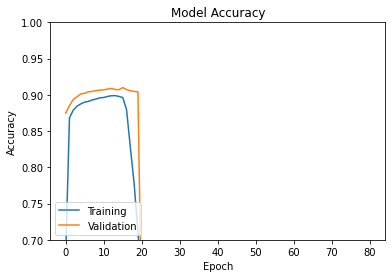

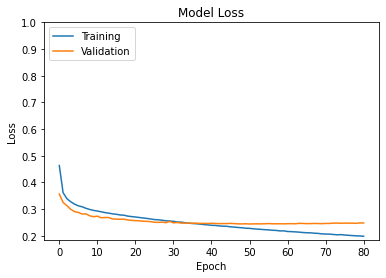


MODEL_PATH:  /content/drive/My Drive/skripsi/run2/dif2model_deep_4_conv_9_featuremap_1024.h5

CONFUSION MATRIX

				PREDICTED

	L	B	E	G	I	H	S	T

 L 	 11111	23	2948	234	0	979	1254	1371

 B 	 572	29	294	14	0	98	71	103

 E 	 2094	17	14759	62	0	407	270	407

 G 	 597	0	194	829	0	852	100	560

 I 	 5	0	0	3	0	18	1	3

 H 	 691	1	346	351	0	23892	141	735

 S 	 3010	5	872	148	0	615	1957	1709

 T 	 1631	1	497	436	0	1714	482	5252


Accuracy:  0.6822273343950923

Precision L :  0.5636953985084471
Precision B :  0.3815789473684211
Precision E :  0.7412857860371672
Precision G :  0.39913336543091
Precision I :  0.0
Precision H :  0.8361154855643045
Precision S :  0.4576707202993452
Precision T :  0.517948717948718

Recall L:  0.6200334821428571
Recall B:  0.024555461473327687
Recall E:  0.8192162522202486
Recall G:  0.26468710089399744
Recall I:  0.0
Recall H:  0.9134075008601904
Recall S:  0.23532948532948533
Recall T:  0.5245181264356337
Testing time:  0:00:05.702192
Restoring model weights from the

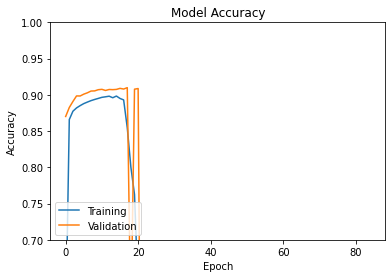

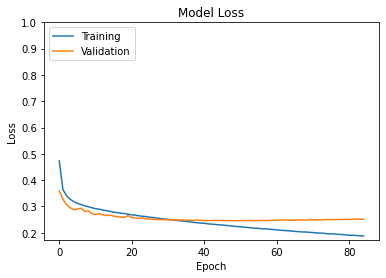


MODEL_PATH:  /content/drive/My Drive/skripsi/run2/dif2model_deep_4_conv_10_featuremap_1024.h5

CONFUSION MATRIX

				PREDICTED

	L	B	E	G	I	H	S	T

 L 	 11013	18	2786	287	0	963	1371	1482

 B 	 560	25	272	20	0	100	90	114

 E 	 2304	23	14511	75	0	337	333	433

 G 	 540	0	187	834	0	840	101	630

 I 	 3	0	1	0	0	22	2	2

 H 	 713	0	302	331	0	23907	137	767

 S 	 2861	2	802	186	0	611	2166	1688

 T 	 1448	1	450	422	0	1714	646	5332


Accuracy:  0.6817436441927682

Precision L :  0.5664540685114701
Precision B :  0.36231884057971014
Precision E :  0.751437004815908
Precision G :  0.3870069605568445
Precision I :  0.0
Precision H :  0.8390187407875342
Precision S :  0.44696657036731324
Precision T :  0.5103369065849923

Recall L:  0.6145647321428571
Recall B:  0.021168501270110076
Recall E:  0.8054507104795737
Recall G:  0.2662835249042146
Recall I:  0.0
Recall H:  0.9139809611193944
Recall S:  0.26046176046176045
Recall T:  0.5325077399380805
Testing time:  0:00:05.986246


weight_temp shape:  (5365, 700)
sample_weight shape:  (5365, 700)
[1.  1.  1.  1.  0.1 1.  1.2 1.1]

MODEL_PATH:  /content/drive/My Drive/skripsi/run2/dif2model_deep_4_conv_7_featuremap_512.h5

CONFUSION MATRIX

				PREDICTED

	L	B	E	G	I	H	S	T

 L 	 11443	19	2833	190	0	993	1120	1322

 B 	 613	29	285	14	0	89	64	87

 E 	 2297	22	14599	61	0	413	252	372

 G 	 644	0	179	856	0	833	92	528

 I 	 4	0	0	0	0	22	0	4

 H 	 762	3	280	286	0	24025	104	697

 S 	 3090	6	837	173	0	635	2007	1568

 T 	 1696	1	451	383	0	1715	496	5271


Accuracy:  0.6869580605202619

Precision L :  0.5568640809771765
Precision B :  0.3625
Precision E :  0.7500513769009454
Precision G :  0.4360672440142639
Precision I :  0.0
Precision H :  0.8363794604003482
Precision S :  0.48536880290205564
Precision T :  0.535181236673774

Recall L:  0.6385602678571428
Recall B:  0.024555461473327687
Recall E:  0.8103352575488455
Recall G:  0.27330779054916987
Recall I:  0.0
Recall H:  0.9184921818251328
Recall S:  0.24134199134199133
Reca

weight_temp shape:  (5365, 700)
sample_weight shape:  (5365, 700)
[1.  1.  1.  1.  0.1 1.  1.2 1.1]

 1   6   512 
Training time:  0:10:01.732014

model_deep_1_ conv_6_featuremap_512


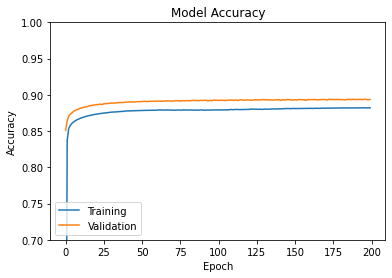

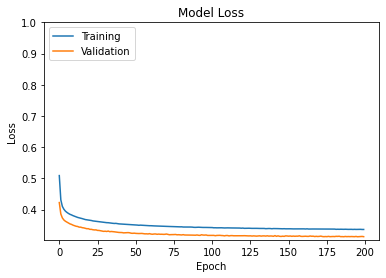


MODEL_PATH:  /content/drive/My Drive/skripsi/run2/dif2model_deep_1_conv_6_featuremap_512.h5

CONFUSION MATRIX

				PREDICTED

	L	B	E	G	I	H	S	T

 L 	 10790	0	2828	11	0	2148	615	1528

 B 	 532	0	334	0	0	186	34	95

 E 	 2631	0	12413	7	0	2338	144	483

 G 	 688	0	190	131	0	1410	65	648

 I 	 5	0	2	0	0	19	0	4

 H 	 1295	0	966	36	0	22935	106	819

 S 	 3471	0	846	15	0	1238	1074	1672

 T 	 1874	0	587	43	0	2353	381	4775


Accuracy:  0.6148528284079514

Precision L :  0.5069059475711736
Precision B :  0.0
Precision E :  0.6833094792469449
Precision G :  0.5390946502057613
Precision I :  0.0
Precision H :  0.7029454133079964
Precision S :  0.4439851178172799
Precision T :  0.4763567438148444

Recall L:  0.6021205357142857
Recall B:  0.0
Recall E:  0.6889986678507993
Recall G:  0.041826309067688375
Recall I:  0.0
Recall H:  0.8768207363229729
Recall S:  0.12914862914862915
Recall T:  0.47688005592729454

 1   7   512 
Training time:  0:10:15.997721

model_deep_1_ conv_7_featuremap_512


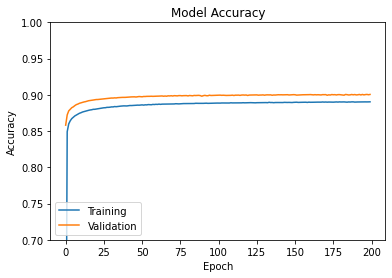

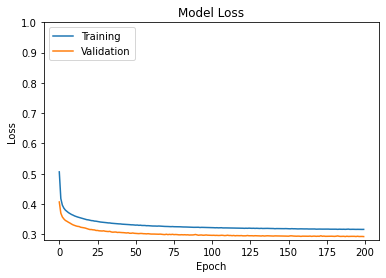


MODEL_PATH:  /content/drive/My Drive/skripsi/run2/dif2model_deep_1_conv_7_featuremap_512.h5

CONFUSION MATRIX

				PREDICTED

	L	B	E	G	I	H	S	T

 L 	 11108	0	2923	23	0	1632	754	1480

 B 	 578	0	302	0	0	153	46	102

 E 	 2484	0	13200	4	0	1697	180	451

 G 	 653	0	214	276	0	1270	83	636

 I 	 3	0	3	0	0	19	0	5

 H 	 1103	0	938	67	0	23145	120	784

 S 	 3439	0	858	23	0	1015	1339	1642

 T 	 1791	0	558	91	0	2186	437	4950


Accuracy:  0.6372677402229694

Precision L :  0.5249775509239567
Precision B :  0.0
Precision E :  0.6948831332912192
Precision G :  0.5702479338842975
Precision I :  0.0
Precision H :  0.743805636790179
Precision S :  0.45251774248056775
Precision T :  0.4925373134328358

Recall L:  0.6198660714285714
Recall B:  0.0
Recall E:  0.7326820603907638
Recall G:  0.08812260536398467
Recall I:  0.0
Recall H:  0.8848491799518293
Recall S:  0.16101491101491103
Recall T:  0.49435733546389693

 1   8   512 
Training time:  0:10:31.775174

model_deep_1_ conv_8_featuremap_512


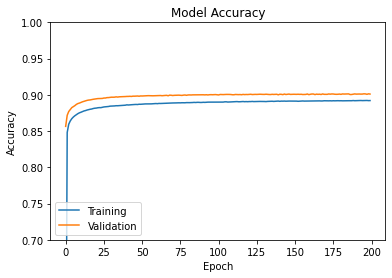

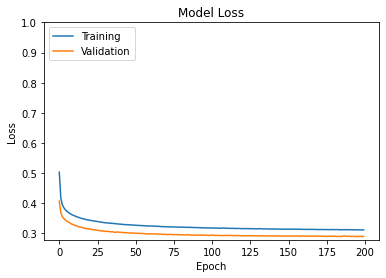


MODEL_PATH:  /content/drive/My Drive/skripsi/run2/dif2model_deep_1_conv_8_featuremap_512.h5

CONFUSION MATRIX

				PREDICTED

	L	B	E	G	I	H	S	T

 L 	 10904	0	2788	28	0	1787	903	1510

 B 	 560	0	293	0	0	160	66	102

 E 	 2467	0	13067	6	0	1787	213	476

 G 	 630	0	195	239	0	1333	104	631

 I 	 3	0	2	0	0	19	1	5

 H 	 1045	0	774	56	0	23434	130	718

 S 	 3251	0	798	22	0	1076	1514	1655

 T 	 1643	0	504	81	0	2310	480	4995


Accuracy:  0.6388603786940364

Precision L :  0.5318246110325319
Precision B :  0.0
Precision E :  0.7093534552955866
Precision G :  0.5532407407407407
Precision I :  0.0
Precision H :  0.7344700056415722
Precision S :  0.4438581061272354
Precision T :  0.4949464922711058

Recall L:  0.6084821428571429
Recall B:  0.0
Recall E:  0.7252997335701599
Recall G:  0.07630906768837803
Recall I:  0.0
Recall H:  0.8958978476124938
Recall S:  0.18205868205868206
Recall T:  0.49885149305902327

 1   9   512 
Training time:  0:10:27.743174

model_deep_1_ conv_9_featuremap_512


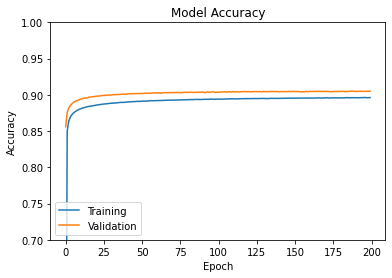

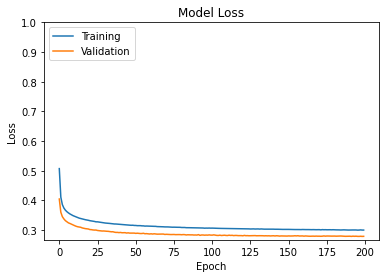


MODEL_PATH:  /content/drive/My Drive/skripsi/run2/dif2model_deep_1_conv_9_featuremap_512.h5

CONFUSION MATRIX

				PREDICTED

	L	B	E	G	I	H	S	T

 L 	 11295	0	2773	48	0	1550	856	1398

 B 	 602	0	286	7	0	127	57	102

 E 	 2569	0	13321	14	0	1477	201	434

 G 	 631	0	189	368	0	1267	98	579

 I 	 4	0	3	0	0	19	0	4

 H 	 979	0	649	94	0	23676	107	652

 S 	 3431	0	813	43	0	969	1483	1577

 T 	 1796	0	507	135	0	2154	461	4960


Accuracy:  0.6500678346015455

Precision L :  0.5301074764162013
Precision B :  0.0
Precision E :  0.7184617873901084
Precision G :  0.5190409026798307
Precision I :  0.0
Precision H :  0.7578987803706905
Precision S :  0.4544897333741955
Precision T :  0.5110241087986812

Recall L:  0.6303013392857143
Recall B:  0.0
Recall E:  0.7393983126110124
Recall G:  0.11749680715197956
Recall I:  0.0
Recall H:  0.9051496731276523
Recall S:  0.17833092833092834
Recall T:  0.4953560371517028

 1   10   512 
Training time:  0:10:43.598953

model_deep_1_ conv_10_featuremap_512


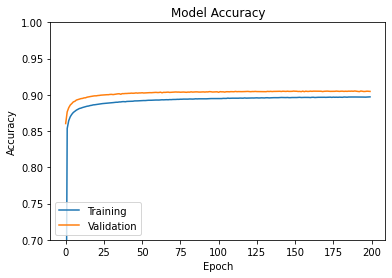

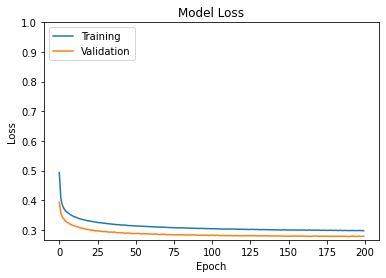


MODEL_PATH:  /content/drive/My Drive/skripsi/run2/dif2model_deep_1_conv_10_featuremap_512.h5

CONFUSION MATRIX

				PREDICTED

	L	B	E	G	I	H	S	T

 L 	 11268	0	2797	50	0	1527	848	1430

 B 	 609	0	281	3	0	140	54	94

 E 	 2513	0	13424	11	0	1457	192	419

 G 	 628	0	188	357	0	1287	84	588

 I 	 5	0	3	0	0	18	0	4

 H 	 941	0	623	77	0	23758	97	661

 S 	 3466	0	803	44	0	994	1399	1610

 T 	 1823	0	475	134	0	2148	443	4990


Accuracy:  0.6511649855482805

Precision L :  0.5301839740271962
Precision B :  0.0
Precision E :  0.7219533182747123
Precision G :  0.5281065088757396
Precision I :  0.0
Precision H :  0.7583389192122315
Precision S :  0.4488290022457491
Precision T :  0.50939158840343

Recall L:  0.6287946428571428
Recall B:  0.0
Recall E:  0.7451154529307282
Recall G:  0.11398467432950192
Recall I:  0.0
Recall H:  0.908284589211301
Recall S:  0.16822991822991823
Recall T:  0.49835214221512036

 2   6   512 
Training time:  0:34:19.762709

model_deep_2_ conv_6_featuremap_512


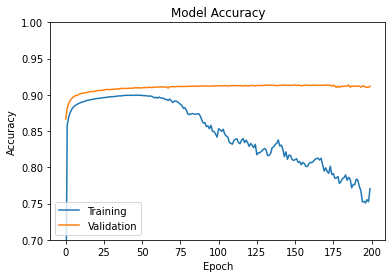

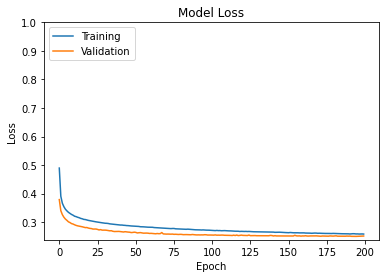


MODEL_PATH:  /content/drive/My Drive/skripsi/run2/dif2model_deep_2_conv_6_featuremap_512.h5

CONFUSION MATRIX

				PREDICTED

	L	B	E	G	I	H	S	T

 L 	 11247	10	2704	118	0	1365	1021	1455

 B 	 583	17	293	2	0	123	63	100

 E 	 2306	14	13990	31	0	974	269	432

 G 	 571	0	171	627	0	1070	86	607

 I 	 6	0	0	0	0	20	0	4

 H 	 657	2	322	166	0	24295	81	634

 S 	 3052	4	749	88	0	868	1873	1682

 T 	 1554	1	407	234	0	2011	468	5338


Accuracy:  0.6770129180675987

Precision L :  0.5630256307569083
Precision B :  0.3541666666666667
Precision E :  0.7506975745868212
Precision G :  0.495260663507109
Precision I :  0.0
Precision H :  0.7906984312959708
Precision S :  0.4851074851074851
Precision T :  0.5206788919235271

Recall L:  0.6276227678571429
Recall B:  0.014394580863674851
Recall E:  0.7765319715808171
Recall G:  0.20019157088122605
Recall I:  0.0
Recall H:  0.9288144664908056
Recall S:  0.22522847522847522
Recall T:  0.533106960950764

 2   7   512 
Training time:  0:36:32.676225

model_deep_2_ co

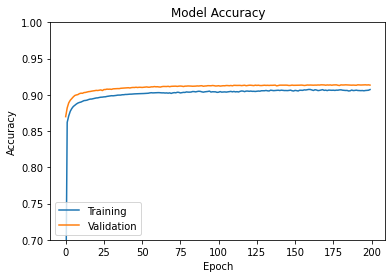

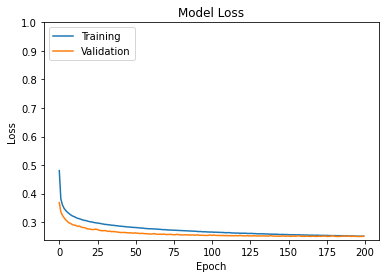


MODEL_PATH:  /content/drive/My Drive/skripsi/run2/dif2model_deep_2_conv_7_featuremap_512.h5

CONFUSION MATRIX

				PREDICTED

	L	B	E	G	I	H	S	T

 L 	 11032	7	2735	113	0	1392	1291	1350

 B 	 581	17	286	7	0	122	73	95

 E 	 2264	13	13987	35	0	1008	320	389

 G 	 560	0	172	646	0	1085	103	566

 I 	 6	0	0	0	0	20	0	4

 H 	 654	1	311	171	0	24306	116	598

 S 	 2934	1	788	94	0	847	2106	1546

 T 	 1562	0	409	271	0	2040	601	5130


Accuracy:  0.6750899545803103

Precision L :  0.5630582350839586
Precision B :  0.4358974358974359
Precision E :  0.7484482020547946
Precision G :  0.4831712789827973
Precision I :  0.0
Precision H :  0.7886437378325762
Precision S :  0.45683297180043386
Precision T :  0.5300681959082455

Recall L:  0.615625
Recall B:  0.014394580863674851
Recall E:  0.7763654529307282
Recall G:  0.2062579821200511
Recall I:  0.0
Recall H:  0.9292350040142218
Recall S:  0.2532467532467532
Recall T:  0.5123339658444023


weight_temp shape:  (5365, 700)
sample_weight shape:  (5365, 700)
[1.  1.  1.  1.  0.1 1.  1.2 1.1]

 3   6   512 
Training time:  0:59:04.661727

model_deep_3_ conv_6_featuremap_512


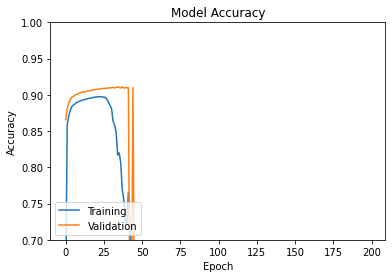

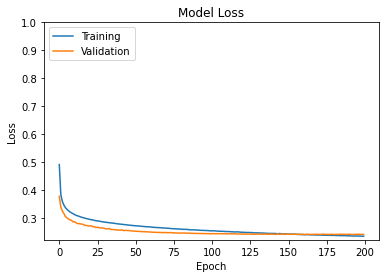


MODEL_PATH:  /content/drive/My Drive/skripsi/run2/dif2model_deep_3_conv_6_featuremap_512.h5

CONFUSION MATRIX

				PREDICTED

	L	B	E	G	I	H	S	T

 L 	 11111	11	3067	172	0	1038	1167	1354

 B 	 584	28	299	14	0	97	68	91

 E 	 2100	22	14753	59	0	450	268	364

 G 	 589	0	206	821	0	874	114	528

 I 	 7	0	0	1	0	18	1	3

 H 	 695	1	356	247	0	24057	117	684

 S 	 2966	4	893	125	0	676	2032	1620

 T 	 1579	2	513	373	0	1712	554	5280


Accuracy:  0.6852120568630921

Precision L :  0.5659925627833529
Precision B :  0.4117647058823529
Precision E :  0.7344551202270125
Precision G :  0.4530905077262693
Precision I :  0.0
Precision H :  0.8317889495885485
Precision S :  0.47026151353853274
Precision T :  0.532043530834341

Recall L:  0.6200334821428571
Recall B:  0.023708721422523286
Recall E:  0.8188832149200711
Recall G:  0.2621328224776501
Recall I:  0.0
Recall H:  0.9197155637114348
Recall S:  0.24434824434824434
Recall T:  0.5273144911614901

 3   7   512 
Training time:  1:03:05.952850

model_deep_3_ 

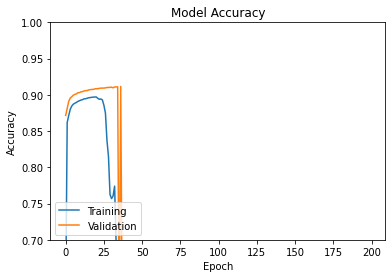

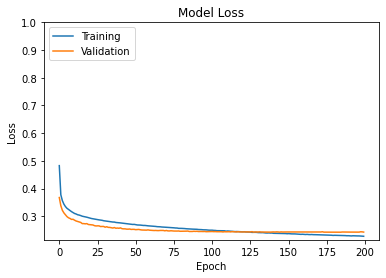


MODEL_PATH:  /content/drive/My Drive/skripsi/run2/dif2model_deep_3_conv_7_featuremap_512.h5

CONFUSION MATRIX

				PREDICTED

	L	B	E	G	I	H	S	T

 L 	 11221	16	2915	209	0	1002	1208	1349

 B 	 601	30	274	14	0	95	78	89

 E 	 2261	17	14557	55	0	454	296	376

 G 	 611	1	217	812	0	837	102	552

 I 	 5	0	1	0	0	19	0	5

 H 	 770	1	324	265	0	23967	117	713

 S 	 3093	3	824	151	0	633	2058	1554

 T 	 1596	3	467	409	0	1690	574	5274


Accuracy:  0.6832890933758037

Precision L :  0.5566524456791349
Precision B :  0.4225352112676056
Precision E :  0.7435006895142755
Precision G :  0.42402088772845953
Precision I :  0.0
Precision H :  0.8351744084747534
Precision S :  0.46424543198736745
Precision T :  0.5320823244552058

Recall L:  0.626171875
Recall B:  0.02540220152413209
Recall E:  0.8080039964476021
Recall G:  0.25925925925925924
Recall I:  0.0
Recall H:  0.9162748021562106
Recall S:  0.2474747474747475
Recall T:  0.5267152701488066
Restoring model weights from the end of the best epoch.
Epoch 00157

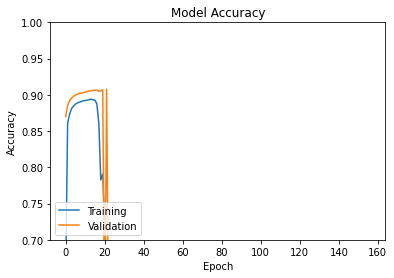

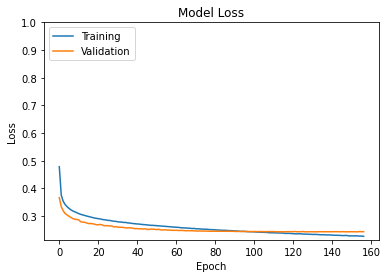


MODEL_PATH:  /content/drive/My Drive/skripsi/run2/dif2model_deep_3_conv_8_featuremap_512.h5

CONFUSION MATRIX

				PREDICTED

	L	B	E	G	I	H	S	T

 L 	 11239	14	2831	226	0	925	1250	1435

 B 	 577	28	284	20	0	90	78	104

 E 	 2243	16	14536	86	0	396	329	410

 G 	 597	0	197	861	0	791	114	572

 I 	 5	0	1	0	0	20	0	4

 H 	 736	2	349	300	0	23895	123	752

 S 	 3019	3	787	178	0	614	2078	1637

 T 	 1541	1	454	428	0	1659	599	5331


Accuracy:  0.683867162154191

Precision L :  0.5631607957107782
Precision B :  0.4375
Precision E :  0.7477750913112814
Precision G :  0.4101953311100524
Precision I :  0.0
Precision H :  0.8416696019725255
Precision S :  0.4546051192299278
Precision T :  0.5203513909224011

Recall L:  0.6271763392857143
Recall B:  0.023708721422523286
Recall E:  0.8068383658969804
Recall G:  0.27490421455938696
Recall I:  0.0
Recall H:  0.9135221929120312
Recall S:  0.24987974987974987
Recall T:  0.5324078697692999
Restoring model weights from the end of the best epoch.
Epoch 00157: earl

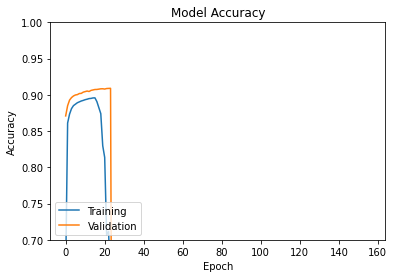

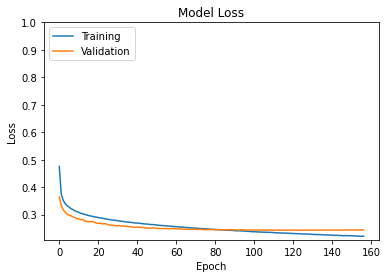


MODEL_PATH:  /content/drive/My Drive/skripsi/run2/dif2model_deep_3_conv_9_featuremap_512.h5

CONFUSION MATRIX

				PREDICTED

	L	B	E	G	I	H	S	T

 L 	 11037	18	2964	205	0	1024	1236	1436

 B 	 581	26	293	10	0	103	77	91

 E 	 2113	17	14691	68	0	421	322	384

 G 	 579	1	203	789	0	852	119	589

 I 	 8	0	0	0	0	18	0	4

 H 	 672	3	342	288	0	24021	134	697

 S 	 2904	5	878	147	0	670	2135	1577

 T 	 1525	2	486	362	0	1738	584	5316


Accuracy:  0.6844216362885625

Precision L :  0.5683608836706319
Precision B :  0.3611111111111111
Precision E :  0.7398398549629853
Precision G :  0.42215088282504015
Precision I :  0.0
Precision H :  0.8327035740284952
Precision S :  0.463425222487519
Precision T :  0.5266494947493561

Recall L:  0.6159040178571429
Recall B:  0.02201524132091448
Recall E:  0.8154418294849023
Recall G:  0.25191570881226055
Recall I:  0.0
Recall H:  0.9183392590893451
Recall S:  0.25673400673400676
Recall T:  0.5309098172375911
Restoring model weights from the end of the best epoch.
Epoc

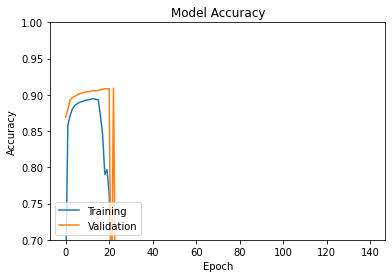

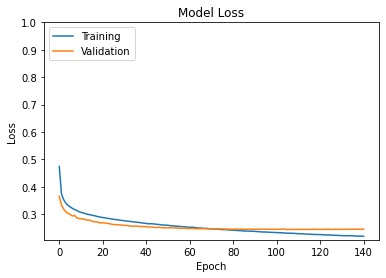


MODEL_PATH:  /content/drive/My Drive/skripsi/run2/dif2model_deep_3_conv_10_featuremap_512.h5

CONFUSION MATRIX

				PREDICTED

	L	B	E	G	I	H	S	T

 L 	 11168	21	2775	238	0	971	1367	1380

 B 	 602	29	269	24	0	84	86	87

 E 	 2265	18	14458	86	0	449	355	385

 G 	 597	0	172	847	0	841	128	547

 I 	 3	0	1	0	0	22	0	4

 H 	 698	1	291	375	0	23903	141	748

 S 	 2963	3	791	156	0	638	2220	1545

 T 	 1574	2	463	436	0	1668	608	5262


Accuracy:  0.6829115790715508

Precision L :  0.5620533467539004
Precision B :  0.3918918918918919
Precision E :  0.7522372528616025
Precision G :  0.39176688251618874
Precision I :  0.0
Precision H :  0.8364711646136618
Precision S :  0.4525993883792049
Precision T :  0.5284193613175336

Recall L:  0.6232142857142857
Recall B:  0.024555461473327687
Recall E:  0.8025088809946714
Recall G:  0.27043422733077904
Recall I:  0.0
Recall H:  0.9138280383836067
Recall S:  0.26695526695526695
Recall T:  0.5255168281234396

 4   6   512 
Training time:  1:23:21.975550

model_deep_4

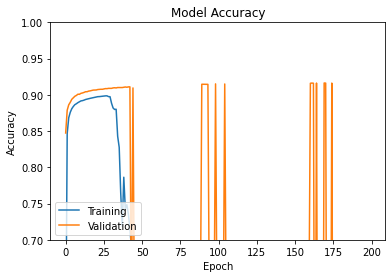

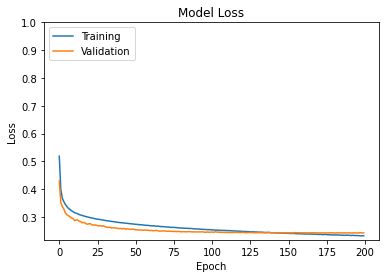


MODEL_PATH:  /content/drive/My Drive/skripsi/run2/dif2model_deep_4_conv_6_featuremap_512.h5

CONFUSION MATRIX

				PREDICTED

	L	B	E	G	I	H	S	T

 L 	 11295	20	2891	205	0	1021	1194	1294

 B 	 598	30	290	12	0	87	74	90

 E 	 2273	30	14553	61	0	484	269	346

 G 	 618	1	186	867	0	850	94	516

 I 	 5	0	0	0	0	21	0	4

 H 	 722	2	317	336	0	24039	104	637

 S 	 3071	6	828	156	0	680	2075	1500

 T 	 1603	2	483	396	0	1775	577	5177


Accuracy:  0.6846693800507285

Precision L :  0.5595739410453306
Precision B :  0.32967032967032966
Precision E :  0.744475138121547
Precision G :  0.426463354648303
Precision I :  0.0
Precision H :  0.830161964291881
Precision S :  0.47298837474356054
Precision T :  0.5413007109995818

Recall L:  0.6303013392857143
Recall B:  0.02540220152413209
Recall E:  0.8077819715808171
Recall G:  0.2768199233716475
Recall I:  0.0
Recall H:  0.9190274114003899
Recall S:  0.24951899951899953
Recall T:  0.5170278637770898
Restoring model weights from the end of the best epoch.
Epoch 00

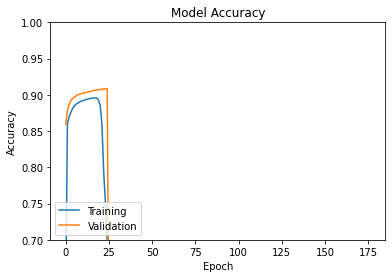

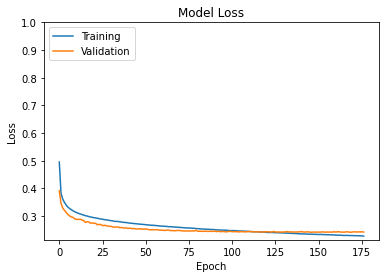


MODEL_PATH:  /content/drive/My Drive/skripsi/run2/dif2model_deep_4_conv_7_featuremap_512.h5

CONFUSION MATRIX

				PREDICTED

	L	B	E	G	I	H	S	T

 L 	 11576	17	2777	178	0	957	1062	1353

 B 	 633	29	267	10	0	84	62	96

 E 	 2387	20	14525	50	0	394	277	363

 G 	 662	0	158	834	0	845	82	551

 I 	 6	0	0	3	0	17	0	4

 H 	 750	2	243	264	0	24045	103	750

 S 	 3257	5	771	136	0	632	1909	1606

 T 	 1673	2	437	362	0	1725	489	5325


Accuracy:  0.6871114257063646

Precision L :  0.5527119938884645
Precision B :  0.38666666666666666
Precision E :  0.7573782459067682
Precision G :  0.45400108873162764
Precision I :  0.0
Precision H :  0.8378340708735496
Precision S :  0.4791666666666667
Precision T :  0.5299562101910829

Recall L:  0.6459821428571428
Recall B:  0.024555461473327687
Recall E:  0.8062277975133215
Recall G:  0.2662835249042146
Recall I:  0.0
Recall H:  0.9192567955040716
Recall S:  0.22955747955747957
Recall T:  0.5318086487566164
Restoring model weights from the end of the best epoch.
Epoch

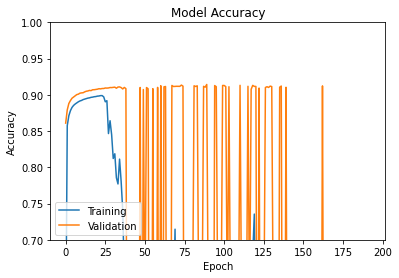

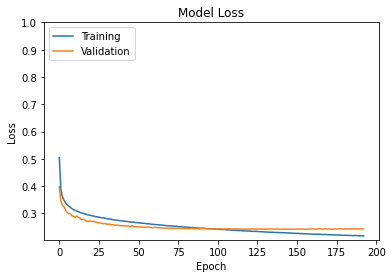


MODEL_PATH:  /content/drive/My Drive/skripsi/run2/dif2model_deep_4_conv_8_featuremap_512.h5

CONFUSION MATRIX

				PREDICTED

	L	B	E	G	I	H	S	T

 L 	 11061	19	2901	217	0	897	1396	1429

 B 	 586	30	281	19	0	80	88	97

 E 	 2176	28	14675	72	0	334	326	405

 G 	 585	0	170	887	0	783	117	590

 I 	 5	0	0	2	0	19	0	4

 H 	 714	3	295	359	0	23890	127	769

 S 	 2930	6	824	150	0	601	2163	1642

 T 	 1567	4	475	413	0	1603	563	5388


Accuracy:  0.685353624727187

Precision L :  0.5636465552384835
Precision B :  0.3333333333333333
Precision E :  0.7479231435706641
Precision G :  0.4185936762623879
Precision I :  0.0
Precision H :  0.8469528840358777
Precision S :  0.452510460251046
Precision T :  0.5218907400232468

Recall L:  0.6172433035714285
Recall B:  0.02540220152413209
Recall E:  0.814553730017762
Recall G:  0.283205619412516
Recall I:  0.0
Recall H:  0.9133310394922965
Recall S:  0.2601010101010101
Recall T:  0.5381004693897933


weight_temp shape:  (5365, 700)
sample_weight shape:  (5365, 700)
[1.  1.  1.  1.  0.1 1.  1.2 1.1]
Restoring model weights from the end of the best epoch.
Epoch 00184: early stopping

 4   9   512 
Training time:  1:31:15.552506

model_deep_4_ conv_9_featuremap_512


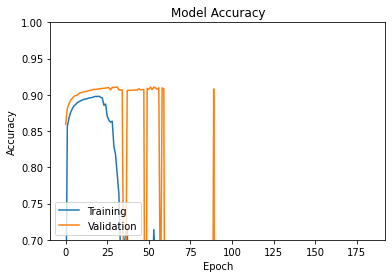

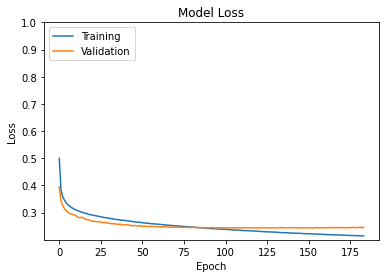


MODEL_PATH:  /content/drive/My Drive/skripsi/run2/dif2model_deep_4_conv_9_featuremap_512.h5

CONFUSION MATRIX

				PREDICTED

	L	B	E	G	I	H	S	T

 L 	 11082	17	2847	265	0	921	1346	1442

 B 	 590	32	280	17	0	89	71	102

 E 	 2155	18	14700	97	0	345	306	395

 G 	 578	0	179	923	0	787	102	563

 I 	 4	0	0	0	0	22	0	4

 H 	 688	2	294	378	0	23914	138	743

 S 	 2926	4	827	212	0	590	2146	1611

 T 	 1566	1	463	480	0	1595	561	5347


Accuracy:  0.6859434908275821

Precision L :  0.5657256623615294
Precision B :  0.43243243243243246
Precision E :  0.7503828483920367
Precision G :  0.3891231028667791
Precision I :  0.0
Precision H :  0.8461239075823515
Precision S :  0.45952890792291223
Precision T :  0.5238561771333399

Recall L:  0.6184151785714286
Recall B:  0.027095681625740897
Recall E:  0.8159413854351687
Recall G:  0.2946998722860792
Recall I:  0.0
Recall H:  0.914248575907023
Recall S:  0.25805675805675804
Recall T:  0.5340057924697893
Restoring model weights from the end of the best epoch.
Epoc

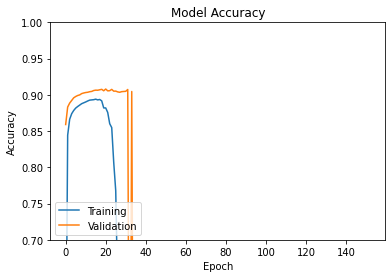

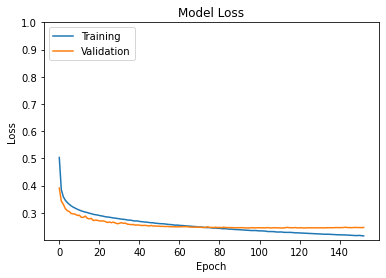


MODEL_PATH:  /content/drive/My Drive/skripsi/run2/dif2model_deep_4_conv_10_featuremap_512.h5

CONFUSION MATRIX

				PREDICTED

	L	B	E	G	I	H	S	T

 L 	 11468	18	2649	253	0	912	1257	1363

 B 	 599	29	271	20	0	78	83	101

 E 	 2469	21	14381	88	0	391	289	377

 G 	 630	0	171	851	0	829	97	554

 I 	 4	0	0	4	0	17	1	4

 H 	 714	1	277	381	0	23899	112	773

 S 	 3109	5	733	173	0	620	2100	1576

 T 	 1694	4	436	436	0	1625	614	5204


Accuracy:  0.6834424585619064

Precision L :  0.5543578092521874
Precision B :  0.3717948717948718
Precision E :  0.7601754942382916
Precision G :  0.385766092475068
Precision I :  0.0
Precision H :  0.8423742554016426
Precision S :  0.4612343509773775
Precision T :  0.5229099678456591

Recall L:  0.6399553571428571
Recall B:  0.024555461473327687
Recall E:  0.7982349023090586
Recall G:  0.2717113665389527
Recall I:  0.0
Recall H:  0.9136751156478189
Recall S:  0.25252525252525254
Recall T:  0.5197243583341656


weight_temp shape:  (5365, 700)
sample_weight shape:  (5365, 700)
[1.  1.  1.  1.  0.1 1.  1.2 1.1]

 5   6   512 
Training time:  1:46:50.851439

model_deep_5_ conv_6_featuremap_512


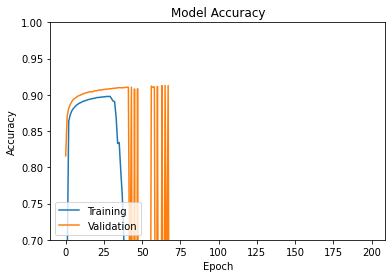

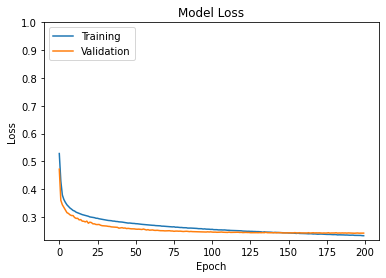


MODEL_PATH:  /content/drive/My Drive/skripsi/run2/dif2model_deep_5_conv_6_featuremap_512.h5

CONFUSION MATRIX

				PREDICTED

	L	B	E	G	I	H	S	T

 L 	 11487	20	2778	233	0	868	1095	1439

 B 	 613	30	280	13	0	80	68	97

 E 	 2339	23	14590	77	0	359	262	366

 G 	 612	1	173	905	0	774	87	580

 I 	 5	0	0	1	0	19	0	5

 H 	 788	5	290	349	0	23898	94	733

 S 	 3183	8	801	170	0	593	1924	1637

 T 	 1589	2	449	406	0	1605	480	5482


Accuracy:  0.6879726302129416

Precision L :  0.5571885913853318
Precision B :  0.33707865168539325
Precision E :  0.7535767780589846
Precision G :  0.4201485608170845
Precision I :  0.0
Precision H :  0.8475670307845085
Precision S :  0.4798004987531172
Precision T :  0.5302253602862946

Recall L:  0.641015625
Recall B:  0.02540220152413209
Recall E:  0.8098357015985791
Recall G:  0.2889527458492976
Recall I:  0.0
Recall H:  0.913636884963872
Recall S:  0.23136123136123135
Recall T:  0.5474882652551682

 5   7   512 
Training time:  1:54:51.611208

model_deep_5_ conv_7_feat

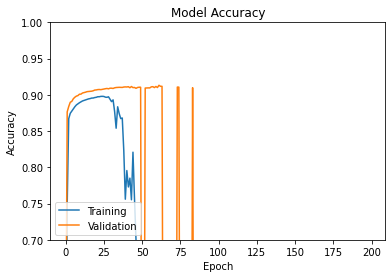

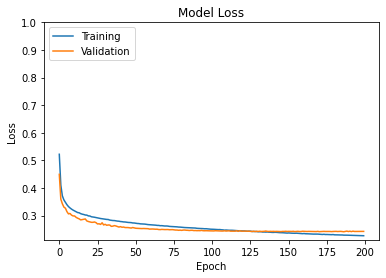


MODEL_PATH:  /content/drive/My Drive/skripsi/run2/dif2model_deep_5_conv_7_featuremap_512.h5

CONFUSION MATRIX

				PREDICTED

	L	B	E	G	I	H	S	T

 L 	 11332	20	2632	207	0	1085	1300	1344

 B 	 621	34	255	12	0	91	69	99

 E 	 2449	23	14251	73	0	545	307	368

 G 	 586	0	162	891	0	845	84	564

 I 	 5	0	0	2	0	18	0	5

 H 	 672	2	203	332	0	24121	102	725

 S 	 3114	4	686	146	0	681	2090	1595

 T 	 1563	1	386	436	0	1739	583	5305


Accuracy:  0.6845278121866336

Precision L :  0.5570740340182873
Precision B :  0.40476190476190477
Precision E :  0.7672139973082099
Precision G :  0.42448785135778944
Precision I :  0.0
Precision H :  0.8281888412017168
Precision S :  0.46085997794928335
Precision T :  0.5302348825587206

Recall L:  0.6323660714285714
Recall B:  0.028789161727349702
Recall E:  0.7910190941385435
Recall G:  0.28448275862068967
Recall I:  0.0
Recall H:  0.9221623274840387
Recall S:  0.25132275132275134
Recall T:  0.5298112453810047
Restoring model weights from the end of the best epoch.
Ep

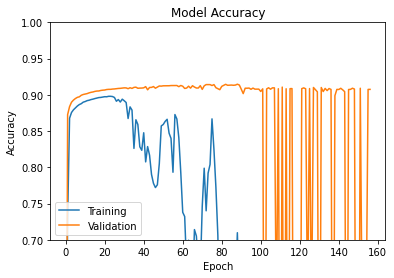

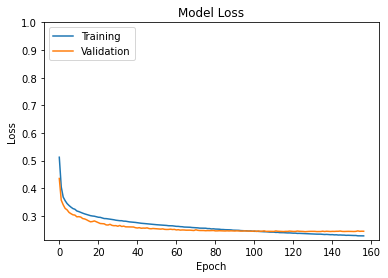


MODEL_PATH:  /content/drive/My Drive/skripsi/run2/dif2model_deep_5_conv_8_featuremap_512.h5

CONFUSION MATRIX

				PREDICTED

	L	B	E	G	I	H	S	T

 L 	 11286	24	2901	194	0	973	1012	1530

 B 	 606	34	277	13	0	99	52	100

 E 	 2293	21	14647	58	0	376	215	406

 G 	 643	2	182	865	0	791	65	584

 I 	 6	0	0	0	0	20	0	4

 H 	 779	2	282	307	0	23955	82	750

 S 	 3283	8	820	141	0	635	1663	1766

 T 	 1684	2	432	376	0	1678	400	5441


Accuracy:  0.6829587683595824

Precision L :  0.5483965014577259
Precision B :  0.3655913978494624
Precision E :  0.7495522235300138
Precision G :  0.44268167860798363
Precision I :  0.0
Precision H :  0.8397307813650227
Precision S :  0.4766408713098309
Precision T :  0.5142236083545979

Recall L:  0.6297991071428571
Recall B:  0.028789161727349702
Recall E:  0.8129995559502664
Recall G:  0.27618135376756064
Recall I:  0.0
Recall H:  0.9158160339488474
Recall S:  0.19997594997594997
Recall T:  0.5433935883351643


### ===================================================================
### SVM
### ===================================================================

### <font color=”blue”>Function for Transfering Feature Maps</font>

In [ ]:
def transfer_feature(input_data):
  model = tf.keras.models.load_model('/content/drive/My Drive/skripsi/run2/dif2model_deep_4_conv_7_featuremap_512.h5')

  layer_name = model.layers[38].name #(38 is the layer before dense layer index if the best model has 4 convolutional layers)
  intermediate_layer_model = Model(
    inputs=model.input,
    outputs=model.get_layer(layer_name).output
  )
    
  feature = intermediate_layer_model.predict(input_data)
  
  if type(feature)==list:
      return feature[:]
  elif type(feature)==np.ndarray:
      return feature.copy()


### <font color=”blue”>Transform CullPDB Data Input</font>

In [ ]:
index_svm = []
flag = np.zeros(8)

svm_target_training = "/content/drive/My Drive/skripsi/run2/svm_cullpdb_target.npy"

reshaped_target = pdb_data.y.reshape(
    pdb_data.y.shape[0]*pdb_data.y.shape[1], 
    pdb_data.y.shape[2]
)

for i in range(reshaped_target.shape[0]):
  if str(reshaped_target[i])!=str(flag):
    index_svm.append(i)

cleaned_target = reshaped_target[index_svm,]
print(reshaped_target.shape)
print(cleaned_target.shape)
np.save(file = svm_target_training, arr = cleaned_target)
           
output_path = "/content/drive/My Drive/skripsi/run2/svm_cullpdb_featuremap.npy"
output = transfer_feature(pdb_data.x)
#reshaped_output = output.reshape(output.shape[0]*output.shape[1], output.shape[2])
#cleaned_output = reshaped_output[index_svm_training,]

reshaped_output = output.reshape(output.shape[0]*output.shape[1], output.shape[2])
cleaned_output = reshaped_output[index_svm,]
print(reshaped_output.shape)
print(cleaned_output.shape)
np.save(file = output_path, arr = cleaned_output)
                       


(3755500, 8)
(1154412, 8)
(3755500, 512)
(1154412, 512)


In [ ]:
L = 0
B = 0
E = 0
G = 0
I = 0
H = 0
S = 0
T = 0
iL = []
iB = []
iE = []
iG = []
iI = []
iH = [] 
iS = [] 
iT = []

target = np.load("/content/drive/My Drive/skripsi/run2/svm_cullpdb_target.npy")

for i in range(len(target)):
    if (np.argmax(target[i])) == 0:
      L = L + 1
      iL.append(i)
    elif (np.argmax(target[i])) == 1:
      B = B + 1
      iB.append(i)
    elif (np.argmax(target[i])) == 2:
      E = E + 1
      iE.append(i)
    elif (np.argmax(target[i])) == 3:
      G = G + 1
      iG.append(i)
    elif (np.argmax(target[i])) == 4:
      I = I + 1
      iI.append(i)
    elif (np.argmax(target[i])) == 5:
      H = H + 1
      iH.append(i)
    elif (np.argmax(target[i])) == 6:
      S = S + 1
      iS.append(i)
    elif (np.argmax(target[i])) == 7:
      T = T + 1
      iT.append(i)      

print(L)
print(B)
print(E)
print(G)
print(I)
print(H)
print(S)
print(T)

221211
11832
250804
45155
212
399879
95133
130186


In [ ]:
import random 
#index = random.sample(iL, 45155) + iB + random.sample(iE, 45155) + iG + iI + random.sample(iH, 45155) + random.sample(iS, 45155) + random.sample(iT, 45155)
index = iL + iB + iE + iG + iI + iH + iS + iT
index.sort()
len(index)

1154412

In [ ]:
path_target = "/content/drive/My Drive/skripsi/run2/svm_cullpdb_target.npy"
path_fm = "/content/drive/My Drive/skripsi/run2/svm_cullpdb_featuremap.npy"

tg = np.load(path_target)
fm = np.load(path_fm)

np.save(arr = tg[index,], file = "/content/drive/My Drive/skripsi/run2/svm_cullpdb_target_filtered.npy")
np.save(arr = fm[index,], file = "/content/drive/My Drive/skripsi/run2/svm_cullpdb_featuremap_filtered.npy")

### =========================

### <font color=”blue”>Transform CB513 Data Input</font>

In [ ]:
index_cb513 = []
flag = np.zeros(8)

In [ ]:
svm_cb513_target = "/content/drive/My Drive/skripsi/run2/dif2svm_target_CB513.npy"

start=datetime.now()                        
        
reshaped_cb513_target = cb513_data.y.reshape(
    cb513_data.y.shape[0]*cb513_data.y.shape[1], 
    cb513_data.y.shape[2]
)
count = 0
for i in range(reshaped_cb513_target.shape[0]):
  if str(reshaped_cb513_target[i])!=str(flag):
    index_cb513.append(i)
    count = count+1

cleaned_target = reshaped_cb513_target[index_cb513,]
print(datetime.now()-start) 
print(reshaped_cb513_target.shape)
print(cleaned_target.shape)
#np.save(file = svm_cb513_target, arr = cleaned_target)


0:01:24.905565
(359800, 8)
(84765, 8)


In [ ]:
output_path = "/content/drive/My Drive/skripsi/run2/dif2svm_featuremap_CB513.npy"
output = transfer_feature(cb513_data.x)
reshaped_output = output.reshape(output.shape[0]*output.shape[1], output.shape[2])
cleaned_output = reshaped_output[index_cb513,]
print(reshaped_output.shape)
print(cleaned_output.shape)
np.save(file = output_path, arr = cleaned_output)


(359800, 512)
(84765, 512)


### <font color=”blue”>Scale Feature Maps</font>

In [ ]:
import numpy as np
from sklearn import preprocessing

unscaled_training = np.load("/content/drive/My Drive/skripsi/run2/svm_cullpdb_featuremap_filtered.npy")
unscaled_cb513 = np.load("/content/drive/My Drive/skripsi/run2/dif2svm_featuremap_CB513.npy")

scaler = preprocessing.MinMaxScaler()
scaler = scaler.fit(unscaled_training)

scaled_training = scaler.transform(unscaled_training)
np.save(file="/content/drive/My Drive/skripsi/run2/scaled_dif2svm_featuremap_training.npy", arr=scaled_training)

scaled_cb513 = scaler.transform(unscaled_cb513)
np.save(file="/content/drive/My Drive/skripsi/run2/scaled_dif2svm_featuremap_CB513.npy", arr=scaled_cb513)


### <font color=”blue”>Prepare Target Data</font>

In [ ]:
train_target = "/content/drive/My Drive/skripsi/run2/svm_cullpdb_target_filtered.npy"
cb513_target = "/content/drive/My Drive/skripsi/run2/dif2svm_target_CB513.npy"

train_target = np.load(train_target)
cb513_target = np.load(cb513_target)

labeled_train_target = []
labeled_cb513_target = []

for i in range(len(train_target)):
    labeled_train_target.append(np.argmax(train_target[i]))
    
for i in range(len(cb513_target)):
    labeled_cb513_target.append(np.argmax(cb513_target[i]))

### <font color=”blue”>Function for Reporting SVM Test Result</font>

In [ ]:
def test_report_svm(model_path, input_data, target_data):
    try:
        model = joblib.load(model_path)  
        test_result = model.predict(input_data)
        target = target_data

        confussion_matrix = [[0 for column in range(8)] for rows in range(8)]

        for sequence_number in range(len(target)):
            actual_class = target[sequence_number]
            predicted_class = test_result[sequence_number]

            confussion_matrix[actual_class][predicted_class] = confussion_matrix[actual_class][predicted_class] + 1

        print("\nMODEL_PATH: ",model_path)              
        generate_report_from_matrix(confussion_matrix)
    except ModuleNotFoundError:
        print("\n",model_path," is not a valid model!\n")

### <font color=”blue”>Train & Test SVM Model</font>

In [ ]:
param_gamma = [1.5]
param_c= [1]

# 1million data non weighted
train_data_path = "/content/drive/My Drive/skripsi/run2/scaled_dif2svm_featuremap_training.npy"
train_data = np.load(train_data_path)
print(len(train_data))

for c in range(len(param_c)):
    for gm in range(len(param_gamma)):
        svm = SVC(
            kernel="rbf",
            gamma = param_gamma[gm],
            C = param_c[c],
            #cache_size = 4000,
            n_jobs = -1,
            max_mem_size = 8000
        )
        
        print("C=",param_c[c]," gamma=",param_gamma[gm])

        start=datetime.now()                        
        svm.fit(X=train_data, y=labeled_train_target)
        print("C=",param_c[c]," gamma=",param_gamma[gm],"\ntraining time: ", datetime.now()-start)     
        saved_path = "/content/drive/My Drive/skripsi/run2/1mil_dif2svm_featuremap_training-c-"+str(param_c[c])+"-gm-"+str(param_gamma[gm])+".pkl"
        svm.save_to_file(saved_path) 

        #cb513
        cbinput = np.load("/content/drive/My Drive/skripsi/run2/scaled_dif2svm_featuremap_CB513.npy")
        datainput = cbinput
        datatarget = labeled_cb513_target
        
        start=datetime.now()                        
        
        test_result = svm.predict(datainput)
        target = datatarget

        confussion_matrix = [[0 for column in range(8)] for rows in range(8)]

        for sequence_number in range(len(target)):
            actual_class = target[sequence_number]
            predicted_class = test_result[sequence_number]

            confussion_matrix[int(actual_class)][int(predicted_class)] = confussion_matrix[int(actual_class)][int(predicted_class)] + 1

        #print("\nMODEL_PATH: ",model_path)              
        generate_report_from_matrix(confussion_matrix)
        print("CB513 C=",param_c[c]," gamma=",param_gamma[gm],"\nTesting time: ", datetime.now()-start)   

1154412
C= 1  gamma= 1.5
C= 1  gamma= 1.5 
training time:  1:31:09.821591

CONFUSION MATRIX

				PREDICTED

	L	B	E	G	I	H	S	T

 L 	 11827	28	2670	269	0	800	1060	1266

 B 	 617	47	252	20	0	79	68	98

 E 	 2546	22	14410	73	0	334	263	368

 G 	 650	1	155	898	0	730	83	615

 I 	 7	0	0	3	0	15	0	5

 H 	 850	1	257	353	0	23725	111	860

 S 	 3302	8	736	165	0	545	2002	1558

 T 	 1717	5	420	421	0	1574	523	5353


Accuracy:  0.6873355748245148

Precision L :  0.5496839561256739
Precision B :  0.41964285714285715
Precision E :  0.7624338624338625
Precision G :  0.407811080835604
Precision I :  0.0
Precision H :  0.8533558736781527
Precision S :  0.4871046228710462
Precision T :  0.5287958115183246

Recall L:  0.6599888392857143
Recall B:  0.03979678238780694
Recall E:  0.7998445825932504
Recall G:  0.28671775223499363
Recall I:  0.0
Recall H:  0.9070229766410521
Recall S:  0.24074074074074073
Recall T:  0.5346050134824728
CB513 C= 1  gamma= 1.5 
Testing time:  0:04:50.368300
C= 1  gamma= 2


1154412
C= 1  gamma= 2
C= 1  gamma= 2 
training time:  1:44:48.040379

CONFUSION MATRIX

				PREDICTED

	L	B	E	G	I	H	S	T

 L 	 11786	24	2678	279	0	810	1082	1261

 B 	 604	47	257	19	0	81	72	101

 E 	 2538	24	14384	79	0	354	269	368

 G 	 651	1	156	874	0	745	85	620

 I 	 6	0	0	4	0	15	0	5

 H 	 844	4	258	356	0	23731	116	848

 S 	 3281	5	738	169	0	547	2032	1544

 T 	 1712	5	420	415	0	1591	550	5320


Accuracy:  0.6862974104878192

Precision L :  0.5501820558304547
Precision B :  0.42727272727272725
Precision E :  0.7614207823831454
Precision G :  0.3981776765375854
Precision I :  0.0
Precision H :  0.8513668651790198
Precision S :  0.48311935330480266
Precision T :  0.5284593225389888

Recall L:  0.6577008928571428
Recall B:  0.03979678238780694
Recall E:  0.7984014209591475
Recall G:  0.2790549169859515
Recall I:  0.0
Recall H:  0.9072523607447337
Recall S:  0.24434824434824434
Recall T:  0.5313092979127134
CB513 C= 1  gamma= 2 
Testing time:  0:05:37.765095
C= 1  gamma= 2.5


1154412
C= 1  gamma= 0.5
C= 1  gamma= 0.5 
training time:  1:04:10.460389

CONFUSION MATRIX

				PREDICTED

	L	B	E	G	I	H	S	T

 L 	 11962	20	2679	254	0	795	967	1243

 B 	 642	41	249	18	0	79	56	96

 E 	 2608	20	14414	61	0	325	230	358

 G 	 685	0	149	900	0	732	73	593

 I 	 6	0	0	4	0	15	0	5

 H 	 872	1	244	350	0	23771	96	823

 S 	 3500	5	730	159	0	544	1835	1543

 T 	 1836	2	416	407	0	1589	462	5301


Accuracy:  0.6868872765882145

Precision L :  0.540997693455746
Precision B :  0.4606741573033708
Precision E :  0.7634129548223081
Precision G :  0.41802136553646074
Precision I :  0.0
Precision H :  0.8535368043087971
Precision S :  0.4934122075826835
Precision T :  0.5321220638426019

Recall L:  0.6675223214285714
Recall B:  0.03471634208298052
Recall E:  0.8000666074600356
Recall G:  0.28735632183908044
Recall I:  0.0
Recall H:  0.9087815881026111
Recall S:  0.22065897065897067
Recall T:  0.5294117647058824
CB513 C= 1  gamma= 0.5 
Testing time:  0:03:09.703004
C= 1  gamma= 0.75
C= 1  gamma=

In [ ]:
param_gamma = [1.25, 1.75]
param_c= [1]

# 1million data non weighted
train_data_path = "/content/drive/My Drive/skripsi/run2/scaled_dif2svm_featuremap_training.npy"
train_data = np.load(train_data_path)
print(len(train_data))

for c in range(len(param_c)):
    for gm in range(len(param_gamma)):
        svm = SVC(
            kernel="rbf",
            gamma = param_gamma[gm],
            C = param_c[c],
            #cache_size = 4000,
            n_jobs = -1,
            max_mem_size = 8000
        )
        
        print("C=",param_c[c]," gamma=",param_gamma[gm])

        start=datetime.now()                        
        svm.fit(X=train_data, y=labeled_train_target)
        print("C=",param_c[c]," gamma=",param_gamma[gm],"\ntraining time: ", datetime.now()-start)     
        saved_path = "/content/drive/My Drive/skripsi/run2/1mil_dif2svm_featuremap_training-c-"+str(param_c[c])+"-gm-"+str(param_gamma[gm])+".pkl"
        svm.save_to_file(saved_path) 

        #cb513
        cbinput = np.load("/content/drive/My Drive/skripsi/run2/scaled_dif2svm_featuremap_CB513.npy")
        datainput = cbinput
        datatarget = labeled_cb513_target
        
        start=datetime.now()                        
        
        test_result = svm.predict(datainput)
        target = datatarget

        confussion_matrix = [[0 for column in range(8)] for rows in range(8)]

        for sequence_number in range(len(target)):
            actual_class = target[sequence_number]
            predicted_class = test_result[sequence_number]

            confussion_matrix[int(actual_class)][int(predicted_class)] = confussion_matrix[int(actual_class)][int(predicted_class)] + 1

        #print("\nMODEL_PATH: ",model_path)              
        generate_report_from_matrix(confussion_matrix)
        print("CB513 C=",param_c[c]," gamma=",param_gamma[gm],"\nTesting time: ", datetime.now()-start)   

1154412
C= 1  gamma= 1.25
C= 1  gamma= 1.25 
training time:  1:28:05.624093

CONFUSION MATRIX

				PREDICTED

	L	B	E	G	I	H	S	T

 L 	 11845	27	2668	273	0	799	1034	1274

 B 	 618	46	252	21	0	79	68	97

 E 	 2557	21	14412	72	0	333	257	364

 G 	 656	1	151	896	0	727	82	619

 I 	 7	0	0	3	0	15	0	5

 H 	 856	1	249	353	0	23739	110	849

 S 	 3333	8	736	162	0	547	1986	1544

 T 	 1742	4	422	419	0	1577	510	5339


Accuracy:  0.6873473721465228

Precision L :  0.5480244286110854
Precision B :  0.42592592592592593
Precision E :  0.7629433562731605
Precision G :  0.40745793542519326
Precision I :  0.0
Precision H :  0.8534296807592753
Precision S :  0.4907338769458858
Precision T :  0.5290853235556436

Recall L:  0.6609933035714286
Recall B:  0.03895004233700254
Recall E:  0.7999555950266429
Recall G:  0.28607918263090676
Recall I:  0.0
Recall H:  0.9075582062163092
Recall S:  0.23881673881673882
Recall T:  0.5332068311195446
CB513 C= 1  gamma= 1.25 
Testing time:  0:04:25.513086
C= 1  gamma= 1.75
C= 1 

In [ ]:
# 1million data non weighted
train_data_path = "/content/drive/My Drive/skripsi/run2/scaled_dif2svm_featuremap_training.npy"
train_data = np.load(train_data_path)
print(len(train_data))

for c in range(len(param_c)):
    for gm in range(len(param_gamma)):
        svm = SVC(
            kernel="rbf",
            gamma = param_gamma[gm],
            C = param_c[c],
            #cache_size = 4000,
            n_jobs = -1,
            max_mem_size = 8000
        )
        
        print("C=",param_c[c]," gamma=",param_gamma[gm])

        start=datetime.now()                        
        svm.fit(X=train_data, y=labeled_train_target)
        print("C=",param_c[c]," gamma=",param_gamma[gm],"\ntraining time: ", datetime.now()-start)     
        saved_path = "/content/drive/My Drive/skripsi/run2/1mil_dif2svm_featuremap_training-c-"+str(param_c[c])+"-gm-"+str(param_gamma[gm])+".pkl"
        svm.save_to_file(saved_path) 

        #cb513
        cbinput = np.load("/content/drive/My Drive/skripsi/run2/scaled_dif2svm_featuremap_CB513.npy")
        datainput = cbinput
        datatarget = labeled_cb513_target
        
        start=datetime.now()                        
        
        test_result = svm.predict(datainput)
        target = datatarget

        confussion_matrix = [[0 for column in range(8)] for rows in range(8)]

        for sequence_number in range(len(target)):
            actual_class = target[sequence_number]
            predicted_class = test_result[sequence_number]

            confussion_matrix[int(actual_class)][int(predicted_class)] = confussion_matrix[int(actual_class)][int(predicted_class)] + 1

        #print("\nMODEL_PATH: ",model_path)              
        generate_report_from_matrix(confussion_matrix)
        print("CB513 C=",param_c[c]," gamma=",param_gamma[gm],"\nTesting time: ", datetime.now()-start)   

1154412
C= 0.01  gamma= 0.001
C= 0.01  gamma= 0.001 
training time:  0:44:08.364325

CONFUSION MATRIX

				PREDICTED

	L	B	E	G	I	H	S	T

 L 	 0	0	0	0	17920	0	0	0

 B 	 0	0	0	0	1181	0	0	0

 E 	 0	0	0	0	18016	0	0	0

 G 	 0	0	0	0	3132	0	0	0

 I 	 0	0	0	0	30	0	0	0

 H 	 0	0	0	0	26157	0	0	0

 S 	 0	0	0	0	8316	0	0	0

 T 	 0	0	0	0	10013	0	0	0


Accuracy:  0.00035391966023712616

Precision L :  0.0
Precision B :  0.0
Precision E :  0.0
Precision G :  0.0
Precision I :  0.00035391966023712616
Precision H :  0.0
Precision S :  0.0
Precision T :  0.0

Recall L:  0.0
Recall B:  0.0
Recall E:  0.0
Recall G:  0.0
Recall I:  1.0
Recall H:  0.0
Recall S:  0.0
Recall T:  0.0
CB513 C= 0.01  gamma= 0.001 
Testing time:  0:06:07.701756
C= 0.01  gamma= 0.01
C= 0.01  gamma= 0.01 
training time:  0:36:01.091847

CONFUSION MATRIX

				PREDICTED

	L	B	E	G	I	H	S	T

 L 	 3691	0	11462	1214	0	1373	78	102

 B 	 89	0	899	83	0	105	3	2

 E 	 102	0	17470	152	0	282	0	10

 G 	 104	0	858	1483	0	673	3	11

 I 	 1	0	6	7	0	16	

1154412
C= 10  gamma= 0.001
C= 10  gamma= 0.001 
training time:  0:30:44.583258

CONFUSION MATRIX

				PREDICTED

	L	B	E	G	I	H	S	T

 L 	 12546	4	2636	187	0	794	656	1097

 B 	 720	13	248	12	0	78	28	82

 E 	 2863	7	14336	50	0	313	141	306

 G 	 793	0	139	875	0	725	38	562

 I 	 7	0	0	3	0	15	0	5

 H 	 1076	0	256	331	0	23755	68	671

 S 	 3997	1	735	136	0	539	1473	1435

 T 	 2221	0	417	372	0	1657	314	5032


Accuracy:  0.684598596118681

Precision L :  0.5179374974198077
Precision B :  0.52
Precision E :  0.7638940693770981
Precision G :  0.44506612410986773
Precision I :  0.0
Precision H :  0.8521667384129717
Precision S :  0.5419426048565121
Precision T :  0.5475516866158868

Recall L:  0.7001116071428571
Recall B:  0.01100762066045724
Recall E:  0.7957371225577264
Recall G:  0.2793742017879949
Recall I:  0.0
Recall H:  0.9081698971594602
Recall S:  0.17712842712842713
Recall T:  0.5025466893039049
CB513 C= 10  gamma= 0.001 
Testing time:  0:02:57.037418
C= 10  gamma= 0.01
C= 10  gamma= 0.01

In [ ]:
# 1mil data weighted
param_gamma = [0.001, 0.01, 0.1, 1]
param_c= [0.01, 0.1, 1, 10]

train_data_path = "/content/drive/My Drive/skripsi/run2/scaled_dif2svm_featuremap_training.npy"
train_data = np.load(train_data_path)
print(len(train_data))

for c in range(len(param_c)):
    for gm in range(len(param_gamma)):
        svm = SVC(
            kernel="rbf",
            gamma = param_gamma[gm],
            C = param_c[c],
            #cache_size = 4000,
            class_weight = 'balanced',
            n_jobs = -1,
            max_mem_size = -1
        )
        
        print("C=",param_c[c]," gamma=",param_gamma[gm])

        start=datetime.now()                        
        svm.fit(X=train_data, y=labeled_train_target)
        print("C=",param_c[c]," gamma=",param_gamma[gm],"\ntraining time: ", datetime.now()-start)     
        saved_path = "/content/drive/My Drive/skripsi/run2/1milbalanced_dif2svm_featuremap_training-c-"+str(param_c[c])+"-gm-"+str(param_gamma[gm])+".pkl"
        svm.save_to_file(saved_path) 

        #cb513
        cbinput = np.load("/content/drive/My Drive/skripsi/run2/scaled_dif2svm_featuremap_CB513.npy")
        datainput = cbinput
        datatarget = labeled_cb513_target
        
        start=datetime.now()                        
        
        test_result = svm.predict(datainput)
        target = datatarget

        confussion_matrix = [[0 for column in range(8)] for rows in range(8)]

        for sequence_number in range(len(target)):
            actual_class = target[sequence_number]
            predicted_class = test_result[sequence_number]

            confussion_matrix[int(actual_class)][int(predicted_class)] = confussion_matrix[int(actual_class)][int(predicted_class)] + 1

        #print("\nMODEL_PATH: ",model_path)              
        generate_report_from_matrix(confussion_matrix)
        print("CB513 C=",param_c[c]," gamma=",param_gamma[gm],"\nTesting time: ", datetime.now()-start)   

1154412
C= 0.01  gamma= 0.001
C= 0.01  gamma= 0.001 
training time:  1:24:29.836507

CONFUSION MATRIX

				PREDICTED

	L	B	E	G	I	H	S	T

 L 	 2647	7862	1244	234	686	113	4905	229

 B 	 23	755	111	10	69	5	195	13

 E 	 213	5118	11313	44	314	18	955	41

 G 	 17	846	25	1028	511	149	449	107

 I 	 0	7	0	3	5	11	3	1

 H 	 47	1068	61	541	6312	17308	529	291

 S 	 120	2570	218	158	468	75	4309	398

 T 	 40	1886	80	603	1439	310	2731	2924


Accuracy:  0.47530230637645254

Precision L :  0.8519472159639524
Precision B :  0.03753977724741448
Precision E :  0.8667637143732762
Precision G :  0.39221671117893936
Precision I :  0.0005099959200326398
Precision H :  0.9621435321585413
Precision S :  0.30612389883489627
Precision T :  0.7302697302697303

Recall L:  0.14771205357142858
Recall B:  0.6392887383573242
Recall E:  0.6279418294849023
Recall G:  0.3282247765006386
Recall I:  0.16666666666666666
Recall H:  0.661696677753565
Recall S:  0.5181577681577682
Recall T:  0.2920203735144312
CB513 C= 0.01  gamma

1154412
C= 0.1  gamma= 0.1
C= 0.1  gamma= 0.1 
training time:  0:39:45.250779

CONFUSION MATRIX

				PREDICTED

	L	B	E	G	I	H	S	T

 L 	 6492	3466	2053	1008	446	338	3106	1011

 B 	 149	521	166	65	52	25	144	59

 E 	 1124	1762	13335	293	264	102	869	267

 G 	 136	313	83	1422	273	322	222	361

 I 	 0	5	0	3	6	10	2	4

 H 	 320	401	224	1010	2573	20251	338	1040

 S 	 907	1299	463	555	351	203	3390	1148

 T 	 389	812	251	1167	675	700	1237	4782


Accuracy:  0.5922137674747833

Precision L :  0.6821477356309762
Precision B :  0.06072968877491549
Precision E :  0.8045248868778281
Precision G :  0.2574687669744704
Precision I :  0.001293103448275862
Precision H :  0.9225547811033666
Precision S :  0.3642028362698754
Precision T :  0.551429889298893

Recall L:  0.36227678571428573
Recall B:  0.441151566469094
Recall E:  0.7401753996447602
Recall G:  0.4540229885057471
Recall I:  0.2
Recall H:  0.7742095806093972
Recall S:  0.40764790764790765
Recall T:  0.4775791471087586
CB513 C= 0.1  gamma= 0.1 
Testi

1154412
C= 0.1  gamma= 1
C= 0.1  gamma= 1 
training time:  0:56:29.562683

CONFUSION MATRIX

				PREDICTED

	L	B	E	G	I	H	S	T

 L 	 6919	3229	2060	1039	45	440	2994	1194

 B 	 164	502	174	71	7	42	143	78

 E 	 1219	1689	13392	304	23	176	861	352

 G 	 158	291	84	1481	28	406	231	453

 I 	 0	5	0	5	0	14	2	4

 H 	 341	499	198	1276	153	21924	392	1374

 S 	 1030	1191	484	570	41	282	3404	1314

 T 	 435	759	258	1235	47	879	1232	5168


Accuracy:  0.622780628797263

Precision L :  0.6739723358659653
Precision B :  0.061481935088793634
Precision E :  0.8043243243243243
Precision G :  0.24761745527503762
Precision I :  0.0
Precision H :  0.9073376650250383
Precision S :  0.36764229398423154
Precision T :  0.5200764818355641

Recall L:  0.3861049107142857
Recall B:  0.42506350550381033
Recall E:  0.7433392539964476
Recall G:  0.4728607918263091
Recall I:  0.0
Recall H:  0.8381695148526207
Recall S:  0.4093314093314093
Recall T:  0.5161290322580645
CB513 C= 0.1  gamma= 1 
Testing time:  0:04:24.179228


1154412
C= 1  gamma= 0.001
C= 1  gamma= 0.001 
training time:  0:55:55.135706

CONFUSION MATRIX

				PREDICTED

	L	B	E	G	I	H	S	T

 L 	 6349	3797	1854	797	939	219	3128	837

 B 	 135	541	153	52	105	12	134	49

 E 	 1189	1975	13013	208	568	40	831	192

 G 	 122	343	69	1322	527	242	210	297

 I 	 0	5	0	4	8	10	2	1

 H 	 270	306	141	873	4494	18912	259	902

 S 	 856	1431	423	449	655	151	3375	976

 T 	 348	897	213	987	1285	528	1286	4469


Accuracy:  0.566141685837315

Precision L :  0.6849714100765995
Precision B :  0.05820333512641205
Precision E :  0.8201815202319426
Precision G :  0.28175618073316283
Precision I :  0.0009322922736277824
Precision H :  0.9402406284180173
Precision S :  0.36585365853658536
Precision T :  0.5786611420432475

Recall L:  0.354296875
Recall B:  0.45808636748518206
Recall E:  0.7223023978685613
Recall G:  0.4220945083014049
Recall I:  0.26666666666666666
Recall H:  0.72301869480445
Recall S:  0.40584415584415584
Recall T:  0.44631978428043545
CB513 C= 1  gamma= 0.001

1154412
C= 1  gamma= 0.1
C= 1  gamma= 0.1 
training time:  0:46:35.580235

CONFUSION MATRIX

				PREDICTED

	L	B	E	G	I	H	S	T

 L 	 6693	3370	2056	1051	111	404	3092	1143

 B 	 157	513	169	70	17	40	145	70

 E 	 1187	1734	13371	311	73	144	873	323

 G 	 150	306	82	1473	98	386	229	408

 I 	 0	5	0	5	4	10	2	4

 H 	 343	504	219	1220	692	21520	397	1262

 S 	 969	1228	477	589	102	262	3441	1248

 T 	 417	782	268	1250	209	833	1255	4999


Accuracy:  0.6136259069191293

Precision L :  0.6749697458652683
Precision B :  0.060767590618336885
Precision E :  0.8034491046749189
Precision G :  0.24677500418830625
Precision I :  0.0030627871362940277
Precision H :  0.9119030467392686
Precision S :  0.3647445410218359
Precision T :  0.5286031511050016

Recall L:  0.37349330357142857
Recall B:  0.4343776460626588
Recall E:  0.7421736234458259
Recall G:  0.4703065134099617
Recall I:  0.13333333333333333
Recall H:  0.8227243185380586
Recall S:  0.4137806637806638
Recall T:  0.4992509737341456
CB513 C= 1  gamma=

1154412
C= 1  gamma= 1
C= 1  gamma= 1 
training time:  1:14:11.708099

CONFUSION MATRIX

				PREDICTED

	L	B	E	G	I	H	S	T

 L 	 7558	2381	2158	1030	1	458	3064	1270

 B 	 212	418	186	75	0	45	156	89

 E 	 1417	1242	13556	325	2	177	918	379

 G 	 180	236	86	1459	4	414	240	513

 I 	 1	5	0	5	0	14	1	4

 H 	 417	353	220	1224	6	22012	437	1488

 S 	 1186	919	506	551	0	285	3496	1373

 T 	 532	590	278	1165	3	920	1254	5271


Accuracy:  0.6343420043650091

Precision L :  0.6570459880031296
Precision B :  0.06803385416666667
Precision E :  0.7978811065332548
Precision G :  0.25008570449091533
Precision I :  0.0
Precision H :  0.904912641315519
Precision S :  0.3654610077357307
Precision T :  0.5074612496389718

Recall L:  0.42176339285714287
Recall B:  0.3539373412362405
Recall E:  0.7524422735346359
Recall G:  0.4658365261813538
Recall I:  0.0
Recall H:  0.8415338150399511
Recall S:  0.4203944203944204
Recall T:  0.5264156596424648
CB513 C= 1  gamma= 1 
Testing time:  0:04:34.048302


## <font color=”blue”>Translate to Humane</font>


In [ ]:
def returnHumane(data):
  tempPrimary = ""
  temp3 = ""
  temp8 = ""
  counter = 0
   
  for i in range(len(data)):
    if((data[i][np.arange(0,20)].astype(int) == np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])).all()):
      tempPrimary = tempPrimary + "-"
    elif((data[i][np.arange(0,20)].astype(int) == np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])).all()):
      tempPrimary = tempPrimary + "A"
    elif((data[i][np.arange(0,20)].astype(int) == np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])).all()):
      tempPrimary = tempPrimary + "C"
    elif((data[i][np.arange(0,20)].astype(int) == np.array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])).all()):
      tempPrimary = tempPrimary + "E"
    elif((data[i][np.arange(0,20)].astype(int) == np.array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])).all()):
      tempPrimary = tempPrimary + "D"
    elif((data[i][np.arange(0,20)].astype(int) == np.array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])).all()):
      tempPrimary = tempPrimary + "G"
    elif((data[i][np.arange(0,20)].astype(int) == np.array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])).all()):
      tempPrimary = tempPrimary + "F"
    elif((data[i][np.arange(0,20)].astype(int) == np.array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])).all()):
      tempPrimary = tempPrimary + "I"
    elif((data[i][np.arange(0,20)].astype(int) == np.array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])).all()):
      tempPrimary = tempPrimary + "H"
    elif((data[i][np.arange(0,20)].astype(int) == np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])).all()):
      tempPrimary = tempPrimary + "K"
    elif((data[i][np.arange(0,20)].astype(int) == np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])).all()):
      tempPrimary = tempPrimary + "M"
    elif((data[i][np.arange(0,20)].astype(int) == np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])).all()):
      tempPrimary = tempPrimary + "L"
    elif((data[i][np.arange(0,20)].astype(int) == np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])).all()):
      tempPrimary = tempPrimary + "N"
    elif((data[i][np.arange(0,20)].astype(int) == np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])).all()):
      tempPrimary = tempPrimary + "Q"
    elif((data[i][np.arange(0,20)].astype(int) == np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])).all()):
      tempPrimary = tempPrimary + "P"
    elif((data[i][np.arange(0,20)].astype(int) == np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])).all()):
      tempPrimary = tempPrimary + "S"
    elif((data[i][np.arange(0,20)].astype(int) == np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])).all()):
      tempPrimary = tempPrimary + "R"
    elif((data[i][np.arange(0,20)].astype(int) == np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])).all()):
      tempPrimary = tempPrimary + "T"
    elif((data[i][np.arange(0,20)].astype(int) == np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])).all()):
      tempPrimary = tempPrimary + "W"
    elif((data[i][np.arange(0,20)].astype(int) == np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])).all()):
      tempPrimary = tempPrimary + "V"
    elif((data[i][np.arange(0,20)].astype(int) == np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])).all()):
      tempPrimary = tempPrimary + "Y"
  
  for i in range(len(data)):
    if((data[i][np.arange(43,51)].astype(int) == np.array([0, 0, 0, 0, 0, 0, 0, 0])).all()):
      temp3 = temp3 + "-"
      temp8 = temp8 + "-"
    elif((data[i][np.arange(43,51)].astype(int) == np.array([1, 0, 0, 0, 0, 0, 0, 0])).all()):
      temp3 = temp3 + "C"
      temp8 = temp8 + "L"
      counter = counter+1
    elif((data[i][np.arange(43,51)].astype(int) == np.array([0, 1, 0, 0, 0, 0, 0, 0])).all()):
      temp3 = temp3 + "E"
      temp8 = temp8 + "B"
      counter = counter+1
    elif((data[i][np.arange(43,51)].astype(int) == np.array([0, 0, 1, 0, 0, 0, 0, 0])).all()):
      temp3 = temp3 + "E"
      temp8 = temp8 + "E"
      counter = counter+1
    elif((data[i][np.arange(43,51)].astype(int) == np.array([0, 0, 0, 1, 0, 0, 0, 0])).all()):
      temp3 = temp3 + "H"
      temp8 = temp8 + "G"
      counter = counter+1
    elif((data[i][np.arange(43,51)].astype(int) == np.array([0, 0, 0, 0, 1, 0, 0, 0])).all()):
      temp3 = temp3 + "C"
      temp8 = temp8 + "I"
      counter = counter+1
    elif((data[i][np.arange(43,51)].astype(int) == np.array([0, 0, 0, 0, 0, 1, 0, 0])).all()):
      temp3 = temp3 + "H"
      temp8 = temp8 + "H"
      counter = counter+1
    elif((data[i][np.arange(43,51)].astype(int) == np.array([0, 0, 0, 0, 0, 0, 1, 0])).all()):
      temp3 = temp3 + "C"
      temp8 = temp8 + "S"
      counter = counter+1
    elif((data[i][np.arange(43,51)].astype(int) == np.array([0, 0, 0, 0, 0, 0, 0, 1])).all()):
      temp3 = temp3 + "C"
      temp8 = temp8 + "T"
      counter = counter+1

  print(tempPrimary)
  print(temp3)
  print(temp8)
  print(counter)

cb513_outputpath = "/content/drive/My Drive/skripsi/cb513_preprocessed.npy"
cbd = np.load(cb513_outputpath)
x = cbd[1]
returnHumane(x)

MFKVYGYDSNIHKCVYCDNAKRLLTVKKQPFEFINIMPEKGVFDDEKIAELLTKLGRDTQIGLTMPQVFAPDGSHIGGFDQLREYFK-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
CEEEEECCCCCCCCHHHHHHHHHHHHCCCCEEEEECCCECCECCHHHHHHHHHHHCCCCCCCCCCCEEECCCCCEEECHHHHHHHCC--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
res = np.load("/content/drive/My Drive/skripsi/SVM Data/prediction_result.npy")

def returnPredictionHumane(data):
  p3 = ""
  p8 = ""

  for i in range(len(data)):
    if data[i] == 0:
      p3 = p3 + "C"
      p8 = p8 + "L"
    elif data[i] == 1:
      p3 = p3 + "E"
      p8 = p8 + "B"
    elif data[i] == 2:
      p3 = p3 + "E"
      p8 = p8 + "E"
    elif data[i] == 3:
      p3 = p3 + "H"
      p8 = p8 + "G"
    elif data[i] == 4:
      p3 = p3 + "C"
      p8 = p8 + "I"
    elif data[i] == 5:
      p3 = p3 + "H"
      p8 = p8 + "H"
    elif data[i] == 6:
      p3 = p3 + "C"
      p8 = p8 + "S"
    elif data[i] == 7:
      p3 = p3 + "C"
      p8 = p8 + "T"
    
  print(p3)
  print(p8)
  print(len(p3))




In [ ]:
returnHumane(cbd[4])
returnPredictionHumane(res[np.arange(108,108+349)])

TPAFNKPKVELHVHLDGAIKPETILYFGKKRGIALPADTVEELRNIIGMDKPLSLPGFLAKFDYYMPVIAGCREAIKRIAYEFVEMKAKEGVVYVEVRYSPHLLANSKVDPMPWNQTEGDVTPDDVVDLVNQGLQEGEQAFGIKVRSILCCMRHQPSWSLEVLELCKKYNQKTVVAMDLAGDETIEGSSLFPGHVEAYEGAVKNGIHRTVHAGEVGSPEVVREAVDILKTERVGHGYHTIEDEALYNRLLKENMHFEVCPWSSYLTGAWDPKTTHAVVRFKNDKANYSLNTDDPLIFKSTLDTDYQMTKKDMGFTEEEFKRLNINAAKSSFLPEEEKKELLERLYREYQ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
CCCCCCCEEEEEEEHHHCCCHHHHHHHHHHHCCCCCCCCHHHHHHHHCCCCCCCHHHHCCHHHHCHHHHCCCHHHHHHHHHHHHHHHHHCCEEEEEEEECCHHHCCCCCCCCHHHCCCCCCCHHHHHHHHHHHHHHHHHHHCCEEEEEEEEECCCCCCHHHHHHHHHHCECCCEEEEEEECCCCCCCHHHCHHHHHHHHHHHHHCCEEEEEECCCCCHHHHHHHHHCCCCCEEEECHHHHHCHHHHHHHHHCCCEEEECHHHHHHCCCCCCCCCCHHHHHHHCCCEEEECCECHHHHCC